In [1]:
# Need to scale problem better
# Need to include the cost function

In [2]:
%reset # clears variables in workspace

# import libraries
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition
import sympy as sym
import numpy as np
from IPython.display import display
from sympy import pprint

# import EOM
import dill
dill.load_session('simplified_biped.db')

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g] + [LL] +\
           [masses[base] for base in bases] +\
           [masses[link,leg] for leg in legs for link in links] +\
           [lengths[base] for base in bases] +\
           [lengths[link,leg] for leg in legs for link in links] +\
           [inertias[base] for base in bases] +\
           [inertias[link,leg] for leg in legs for link in links] +\
           [x_body]+[y_body]+[th_body] + [th[link,leg] for leg in legs for link in links if 'foot' not in link] +\
           [dx_body]+[dy_body]+[dth_body] + [dth[link,leg] for leg in legs for link in links if 'foot' not in link] +\
           [ddx_body]+[ddy_body]+[ddth_body] + [ddth[link,leg] for leg in legs for link in links if 'foot' not in link] +\
           [tau['left',leg] for leg in legs] + [tau['right',leg] for leg in legs] +\
           [lamda['x',leg] for leg in legs] + [lamda['y',leg] for leg in legs] +\
           [GRF['x',leg] for leg in legs] + [GRF['y',leg] for leg in legs]

lamb_EOMs = {}

DOFs = ['x_body'] + ['y_body'] +['theta_body']

for leg in legs:
    for link in links:
        if 'foot' not in link:
            DOFs = DOFs + ['theta_{0}'.format(link+leg)]

for dof_i,dof in enumerate(DOFs):
    lamb_EOMs.update({dof: sym.lambdify(sym_list,EOMs[dof_i],modules = [func_map])})

    
# PARAMETERS:
masses_ = {'body': 5756.78/1000 + (485/1000) + (800/1000),
           'ullA': 153.81/1000,
           'lllA': 346.45/1000,
           'urlA': 153.81/1000,
           'lrlA': 346.45/1000,
           'ullB': 153.81/1000,
           'lllB': 346.45/1000,
           'urlB': 153.81/1000,
           'lrlB': 346.45/1000}

lengths_ = {'body': 24/100,
            'ullA': 17.5/100,
            'lllA': 30.0/100,
            'urlA': 17.5/100,
            'lrlA': 30.0/100,
            'ullB': 17.5/100,
            'lllB': 30.0/100,
            'urlB': 17.5/100,
            'lrlB': 30.0/100}

''' ****** '''
inertias_ = {'body': 32124078.52*1e-9, # body rotate about its center 
            'ullA': 600933.68*1e-9, # rotates as pendulumn 
            'urlA': 600933.68*1e-9,
            'lllA': 4659658.63*1e-9,
            'lrlA': 4659658.63*1e-9,
            'ullB': 600933.68*1e-9, # rotates as pendulumn 
            'urlB': 600933.68*1e-9,
            'lllB': 4659658.63*1e-9,
            'lrlB': 4659658.63*1e-9}

total_mass = 0.0
for mass in masses_:
    total_mass += masses_[mass]
total_mass

WDOFs = ['X','Y'] 
signs = ['-ve','+ve'] 
legs = ['A','B']
links = ['ull','lll','url','lrl']
bases = ['body']
ground_constraints = ['contact','friction','slip_+ve','slip_-ve'] # Group all constraints occuring at the ground
sides = ['left','right']
coordinates = {'X':0 , 'Y':1}
motor_w_angle = {'left': 'ull' ,'right': 'url'}
all_links = []
for leg in legs:
    for link in links:
        all_links.append(link+leg)
        
[all_links.append(base) for base in bases]

def get_var_list_zeros(m,n):
    var_list = [m.g] + [m.LL] +\
               [m.masses[base] for base in bases] +\
               [m.masses[link+leg] for leg in legs for link in links] +\
               [m.lengths[base] for base in bases] +\
               [m.lengths[link+leg] for leg in legs for link in links] +\
               [m.inertias[base] for base in bases] +\
               [m.inertias[link+leg] for leg in legs for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [0 for leg in legs] + [0 for leg in legs] +\
               [0 for leg in legs] + [0 for leg in legs] +\
               [0 for leg in legs] + [0 for leg in legs]
    return var_list

def get_var_list_values(m,n):
    
    BW = 1
    tau_value = {}
    connection_force_value = {}
    GRF_X_value = {}
    GRF_Y_value = {}
    
    for leg in legs:
        
        [tau_value.update({(side,leg): BW*(m.tau_torque[n,side,leg])}) for side in sides]
        #[connection_force_value.update({(wdof,leg):BW*(m.connect_force[n,'+ve',wdof,leg]-m.connect_force[n,'-ve',wdof,leg])}) for wdof in WDOFs]
        #[connection_force_value.update({(wdof,leg):0.0})for wdof in WDOFs]
        [connection_force_value.update({(wdof,leg):BW*(m.connect_force[n,wdof,leg])}) for wdof in WDOFs]
        GRF_X_value.update({(leg):BW*(m.GRF_x[n,'+ve',leg]-m.GRF_x[n,'-ve',leg])})
        GRF_Y_value.update({(leg):BW*(m.GRF_y[n,leg])})

    var_list = [m.g] + [m.LL] +\
               [m.masses[base] for base in bases] +\
               [m.masses[link+leg] for leg in legs for link in links] +\
               [m.lengths[base] for base in bases] +\
               [m.lengths[link+leg] for leg in legs for link in links] +\
               [m.inertias[base] for base in bases] +\
               [m.inertias[link+leg] for leg in legs for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [tau_value['left',leg] for leg in legs] + [tau_value['right',leg] for leg in legs] +\
               [connection_force_value['X',leg] for leg in legs] + [connection_force_value['Y',leg] for leg in legs] +\
               [GRF_X_value[leg] for leg in legs] + [GRF_Y_value[leg] for leg in legs]
    return var_list



Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  clears, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details
Flushing input history
Don't know how to reset  workspace, please run `%reset?` for details


--------------
Stall torque =  140.4238410596027
Max speed =  55.8
--------------


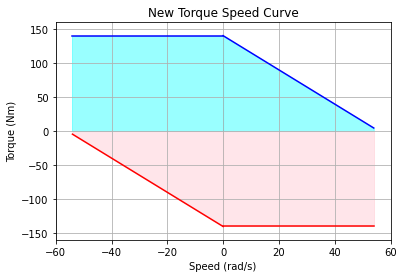

In [3]:
'''Plot Torque Speed Curve'''
import matplotlib.pyplot as plt
x_p = np.linspace(0, 54, num=54)
x_n = np.linspace(-54, 0, num=54)
no_load_speed = 55.8
# from graph
max_torque = 38.0
speed_max_torque = 40.7

m_grad = (max_torque-0.0)/(speed_max_torque-no_load_speed)

stall_torque = 0.0 - m_grad*no_load_speed

y_p = m_grad*x_p+stall_torque
y_n = m_grad*x_n-stall_torque

stall_torque_p = []
stall_torque_n = []
rated_torque_p = []
rated_torque_n = []

for ii in range(len(x_p)):
    stall_torque_p.append(stall_torque)
    stall_torque_n.append(-stall_torque)
    rated_torque_p.append(max_torque)
    rated_torque_n.append(-max_torque)

plt.grid()
plt.plot(x_p, y_p,'b')
plt.plot(x_n, stall_torque_p,'b')

plt.fill_between(x_p, y_p, alpha=0.4, color = 'cyan')
plt.fill_between(x_n, stall_torque_p, alpha=0.4,color = 'cyan')

plt.plot(x_n, y_n,'r')
plt.plot(x_p, stall_torque_n,'r')

plt.fill_between(x_n, y_n, alpha=0.4,color = 'pink')
plt.fill_between(x_p, stall_torque_n, alpha=0.4,color = 'pink')

plt.axis((-60,60,-160,160))
plt.title('New Torque Speed Curve')
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')
print('--------------')

print('Stall torque = ',stall_torque)
print('Max speed = ',no_load_speed)

print('--------------')

In [4]:
FOR_LOOP_RUN = False

<a id='Select_Test'></a>

In [5]:
tests = {0:"High_Drop_Test",1:"Low_Drop_Test", 2:"Hop_Test", 3:"Drop_Hop_Test",\
         4:"Standing_Test", 5:"Tax_Day_Sprint",6:"Missing_the_Boat",\
         7:"Periodic_Hop",8:"Periodic_Run",9:"Stop_Periodic_Run_Flight",10:"Start_Periodic_Run",\
         11:"High_Drop_Move_Leg", 12:"Forward_Hop", 13:"Stop_Periodic_Run_MidStance"}

if FOR_LOOP_RUN == False:

    test = tests[9]
    V_avg = 8.0
    mu_value = 0.5
    h_lower_bound = 0.5
    h_higher_bound = 1.0

    if test == "High_Drop_Test" or test == "Low_Drop_Test" or test == "Standing_Test":
        N = 50
        TT = 0.2
    elif test == "High_Drop_Move_Leg":
        N = 50
        TT = 0.4
    elif test == "Forward_Hop":
        N = 50
        TT = 0.7
        x_final = 2.0 # for display
    elif test == "Hop_Test" or test == "Drop_Hop_Test":
        N = 50
        TT = 1.0
    elif test == "Tax_Day_Sprint":
        N = 50
        TT = 1.5
        x_final = 5.0
    elif test == "Missing_the_Boat":
        N = 50
        TT = 1.0
        x_final = 5.0
    elif test == "Periodic_Hop":
        N = 50
        TT = 1.0 # 2Hz but only half a gait due to symmetry
        dy_periodic = 0.5
    elif test == "Periodic_Run":
        # u 0.5 [N = 100 and TT = 0.15 0.5<h<1.5]
        # u 1.0 [N = 100 and TT = 0.3 0.8<h<1.2]
        N = 100 #100
        TT = 0.3 #0.5 #0.3 # 2Hz but only half a gait due to symmetry
        V_flight = 0.75*sqrt(9.81*(0.18+0.35)) # from paper
        x_final = 3.0 # for display

    elif test == "Stop_Periodic_Run_Flight" or test == "Start_Periodic_Run" or test == "Stop_Periodic_Run_MidStance":

        import csv
        file = open(str(round(V_avg))+'_u1.0.csv'.format(str(mu_value)))
        csvreader = csv.reader(file)

        rows = []
        for row in csvreader:
            rows.append(row)

        stored_values = {}
        headers = rows[0]

        for item in rows:
            if item[0] == 'node': # remove headers
                pass
            else: 
                for header_loc in range(len(headers)):
                    if header_loc == 0: # don't want 'node' as header - only its value
                        pass 
                    else:
                        stored_values.update({(headers[header_loc],int(item[0])):float(item[header_loc])})

            #initial_conditions[item[0]] = float(item[1])
        x_final = 5.0 # for display 

        if test == "Stop_Periodic_Run_Flight":
            # done [100,1.5 and ]
            N = 100 #50
            TT = 1.5 # 1.0 2Hz but only half a gait due to symmetry
        elif test == "Stop_Periodic_Run_MidStance":
            N = 100
            TT = 1.5
        elif test == "Start_Periodic_Run":
            N = 50
            TT = 1.0
        else: pass   

    else:
        pass
    
###################################################################################
else:
    
    test = tests[9]
    V_avg = 8.0

    h_lower_bound = 0.5
    h_higher_bound = 1.0

    if test == "Stop_Periodic_Run_Flight" or test == "Start_Periodic_Run":

        import csv
        file = open(str(round(V_avg))+'_u{0}.csv'.format(str(mu_value)))
        csvreader = csv.reader(file)

        rows = []
        for row in csvreader:
            rows.append(row)

        stored_values = {}
        headers = rows[0]

        for item in rows:
            if item[0] == 'node': # remove headers
                pass
            else: 
                for header_loc in range(len(headers)):
                    if header_loc == 0: # don't want 'node' as header - only its value
                        pass 
                    else:
                        stored_values.update({(headers[header_loc],int(item[0])):float(item[header_loc])})

            #initial_conditions[item[0]] = float(item[1])
        x_final = 7.0 # for display  

    else:
        pass



In [6]:
if 'Stop' in test: 
    GRF_yA_array = []
    GRF_yB_array = []
    for n in range (N):
        GRF_yA_array.append(stored_values['GRF_yA',n])
        GRF_yB_array.append(stored_values['GRF_yB',n])

    print(max(GRF_yA_array))
    print(max(GRF_yB_array))
    max_GRFA = max(GRF_yA_array)
    max_GRFB = max(GRF_yB_array)
    max_index = GRF_yB_array.index(max(GRF_yB_array))
    print(max_index)
    midstance_node = max_index+1
else: 
    pass

0.0
887.1005325229859
41


In [7]:
print("test = ",test)
print("total mass = " ,total_mass)
print("mu = ",mu_value)
print("V_avg = ",V_avg)
print("N = ",N)
print("TT = ",TT)

if TT/N < 0.01 or TT/N>0.02:
    print('Exceeded hm: ',TT/N)
else:
    print('Passed hm: ',TT/N)
    


test =  Stop_Periodic_Run_Flight
total mass =  9.042820000000003
mu =  0.5
V_avg =  8.0
N =  100
TT =  2.0
Passed hm:  0.02


In [8]:
m = ConcreteModel('Biped')

#SETS-------------------------
m.N = RangeSet(N)
m.ground_constraints = Set(initialize = ground_constraints)
m.legs = Set(initialize = legs)
m.links = Set(initialize = links)
m.bases = Set(initialize = bases)
m.all_links = Set(initialize = all_links)
m.DOFs = Set(initialize = DOFs)
m.WDOFs = Set(initialize = WDOFs)
m.signs = Set(initialize = signs)
m.sides = Set(initialize = sides)


#Params--------------------------
m.g = Param(initialize = 9.81)
m.LL = Param(initialize = 7.5/100)

# m.masses = Param(m.links, initialize = masses)
m.masses = Param(m.all_links, initialize = masses_)
m.lengths = Param(m.all_links, initialize = lengths_)
m.inertias = Param(m.all_links, initialize = inertias_)


#VARIABLES----------------------
#gen coordinates
m.q = Var(m.N,m.DOFs)
m.dq = Var(m.N,m.DOFs)
m.ddq = Var(m.N,m.DOFs)

In [9]:
''' CONSTRAINTS  - Integration'''
# variable timestep
hm = TT/N # master timestep
m.h = Var(m.N, bounds = (h_lower_bound,h_higher_bound)) #m.h = Var(m.N, bounds = (0.5,1.5))

def BwEuler_p(m,n,dof):
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip
m.integrate_p = Constraint(m.N, m.DOFs, rule = BwEuler_p)

def BwEuler_v(m,n,dof):
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOFs, rule = BwEuler_v)

In [10]:
''' CONSTRAINTS  - CONNECTION POINT'''
m.connect_position = Var(m.N, m.WDOFs, m.sides, m.legs) # connection point
m.connect_force = Var(m.N, m.WDOFs, m.legs,bounds = (-10*total_mass*9.81,10*total_mass*9.81)) # connection force

# Lamdify
lamb_connect_position = {} # (WDOFs,sides,leg)
[lamb_connect_position.update({(wdof,side,leg): sym.lambdify(sym_list,connect_foot_position[side,leg][coordinates[wdof]],modules = [func_map])}) for leg in legs for side in sides for wdof in WDOFs]

# Equate the connection equations from the previous script to the model m
def def_connect_position_equation(m,n,wdof,side,leg):
    var_list = get_var_list_zeros(m,n)    
    return m.connect_position[n,wdof,side,leg] == lamb_connect_position[wdof,side,leg](*var_list)
m.connect_position_equation = Constraint(m.N, m.WDOFs, m.sides, m.legs, rule = def_connect_position_equation)

# Ensure that there is no distance between the X (and Y) of link connection points
def def_connect_position(m,n,wdof,leg):
    return  m.connect_position[n,wdof,'right',leg] - m.connect_position[n,wdof,'left',leg] == 0.0
m.connect_position_constraint = Constraint(m.N, m.WDOFs, m.legs, rule= def_connect_position)

In [11]:
#Variable of foot position
m.foot_position = Var(m.N, m.WDOFs, m.legs)
for n in range(1,N+1):
    for leg in legs:
        m.foot_position[n,'Y',leg].setlb(0.0)

#Get the foot position in WDOF
lamb_foot_position = {}
[lamb_foot_position.update({(wdof,leg): sym.lambdify(sym_list,connect_foot_position['right',leg][coordinates[wdof]],modules = [func_map])}) for leg in legs for wdof in WDOFs]

def def_foot_position(m,n,wdof,leg):
    var_list = get_var_list_zeros(m,n)
    return m.foot_position[n,wdof,leg] == lamb_foot_position[wdof,leg](*var_list)
m.def_foot_position = Constraint(m.N, m.WDOFs, m.legs, rule = def_foot_position)

m.mu = Param(initialize = mu_value,within=Any)

# Variables
m.foot_velocity = Var(m.N, m.WDOFs, m.signs, m.legs, bounds = (0.0,None)) # the sign will account for -ve velocities
m.friction_cone = Var(m.N, m.legs, bounds = (0.0,None)) 
m.GRF_y = Var(m.N, m.legs, bounds = (0.0,10*total_mass*m.g.value)) # ground reaction forces
m.GRF_x = Var(m.N, m.signs, m.legs, bounds = (0.0,10*total_mass*m.g.value)) # ground reaction forces

'''******'''
m.ground_penalty = Var(m.N, m.ground_constraints, m.legs, bounds = (0.0,10.0)) # penalty

lamb_foot_velocity_x = {}

# Get the foot position in WDOF
[lamb_foot_velocity_x.update({(leg): sym.lambdify(sym_list,(connect_foot_position['right',leg].jacobian(q)*dq)[0].simplify(),modules = [func_map])}) for leg in legs]

# CONSTRAINTS
def def_foot_velocity(m,n,wdof,leg):
    if wdof == 'X':
        var_list = get_var_list_zeros(m,n)
        return m.foot_velocity[n,'X','+ve',leg]-m.foot_velocity[n,'X','-ve',leg] == lamb_foot_velocity_x[leg](*var_list)
    else: return Constraint.Skip
m.foot_velocity_constraint = Constraint(m.N, m.WDOFs, m.legs, rule = def_foot_velocity)

def def_friction_cone(m,n,leg):
    return m.friction_cone[n,leg] == m.mu*m.GRF_y[n,leg] - (m.GRF_x[n,'+ve',leg] + m.GRF_x[n,'-ve',leg])
m.friction_cone_constraint = Constraint(m.N, m.legs, rule = def_friction_cone)

# constraints: complementarity

# contact
def def_ground_contact(m,n,leg):
    if n < N:
        return m.foot_position[n+1,'Y',leg]*m.GRF_y[n,leg] <= m.ground_penalty[n,'contact',leg]
    else:
        return Constraint.Skip
m.ground_contact_constraint = Constraint(m.N, m.legs, rule = def_ground_contact)

# friction
def def_ground_friction(m,n,leg):
    return (m.foot_velocity[n,'X','+ve',leg]+m.foot_velocity[n,'X','-ve',leg])*m.friction_cone[n,leg] <= m.ground_penalty[n,'friction',leg]
m.ground_friction_constraint = Constraint(m.N, m.legs, rule = def_ground_friction)

# slipping
def def_ground_slip_positive(m,n,leg):
    return m.foot_velocity[n,'X','+ve',leg]*m.GRF_x[n,'+ve',leg] <= m.ground_penalty[n,'slip_+ve',leg]
m.ground_slip_positive_constraint = Constraint(m.N, m.legs, rule = def_ground_slip_positive)

def def_ground_slip_negative(m,n,leg):
    return m.foot_velocity[n,'X','-ve',leg]*m.GRF_x[n,'-ve',leg] <= m.ground_penalty[n,'slip_-ve',leg]
m.ground_slip_negative_constraint = Constraint(m.N, m.legs, rule = def_ground_slip_negative)

#bound contact forces at last node
for leg in legs:
    m.GRF_y[N,leg].fix(0.0)
    for sgn in signs:
        m.GRF_x[N,sgn,leg].fix(0.0)


In [12]:
'''Torque Speed - Speed Torque Curve'''

m.tau_torque = Var(m.N, m.sides, m.legs, bounds = (-max_torque,max_torque))
m.tau_velocity = Var(m.N, m.sides, m.legs, bounds = (-no_load_speed,no_load_speed))

lamb_tau_velocity = {}
[lamb_tau_velocity.update({(side,leg): sym.lambdify(sym_list,w_links[motor_w_angle[side],leg],modules = [func_map])}) for leg in legs for side in sides]

def def_angular_velocity(m,n,side,leg):
    var_list = get_var_list_zeros(m,n)
    return m.tau_velocity[n,side,leg] == lamb_tau_velocity[side,leg](*var_list)
m.left_angular_velocity_constraint = Constraint(m.N, m.sides, m.legs, rule = def_angular_velocity)

# assume straight line
def def_constant_power_right(m,n,side,leg):
    return m.tau_torque[n,side,leg] <= m.tau_velocity[n,side,leg]*m_grad + stall_torque
m.constant_power_right_constraint = Constraint(m.N, m.sides, m.legs, rule = def_constant_power_right)

def def_constant_power_left(m,n,side,leg):
    return m.tau_torque[n,side,leg] >= m.tau_velocity[n,side,leg]*m_grad - stall_torque
m.constant_power_left_constraint = Constraint(m.N, m.sides, m.legs, rule = def_constant_power_left)

In [13]:
# Set the angles for the knees - only use this when actuated 
# This ensures links does not cross
m.knee_angle = Var(m.N, m.sides, m.legs, bounds = (0.0,170*(np.pi)/180))

def def_knee_angle(m,n,side,leg):
    if side == 'left':
        return m.knee_angle[n,side,leg] == 2*np.pi - m.q[n,'theta_lll'+leg]
    else:
        return m.knee_angle[n,side,leg] == m.q[n,'theta_lrl'+leg]   
m.knee_angle_constraint = Constraint(m.N, m.sides, m.legs, rule = def_knee_angle)

In [14]:
# Get the foot position in WDOF
if test == "Periodic_Run" or test == "Periodic_Hop":
    
    lamb_body_position_x = sym.lambdify(sym_list,(r_bases['body'])[0].simplify(),modules = [func_map])
    m.body_position = Var(m.N, m.WDOFs) # the sign will account for -ve velocities

    # CONSTRAINTS
    def def_body_position(m,n,wdof):
        var_list = get_var_list_zeros(m,n)
        if wdof == 'X':
            return m.body_position[n,'X'] == lamb_body_position_x(*var_list)
        else: return Constraint.Skip
    m.body_position_constraint = Constraint(m.N, m.WDOFs, rule = def_body_position)
    
    
    if test == "Periodic_Run":
        
        # Average velocities
        def def_body_position_average(m,wdof):
            if wdof == 'X':
                return (m.body_position[N,'X'] - m.body_position[1,'X'])/(sum(hm*m.h[n] for n in range(1,N+1))) == V_avg
            else: return Constraint.Skip
        m.def_body_position_average_constraint = Constraint(m.WDOFs, rule = def_body_position_average)
        
        # Equate states
        def def_equate_position_states(m,n,dof_i):
            if dof_i == 'y_body' or dof_i == 'theta_body':
                return m.q[1,dof_i] == m.q[N,dof_i]
            
            elif dof_i == 'theta_ullA':
                return m.q[1,'theta_ullA'] == m.q[N,'theta_ullB']
            elif dof_i == 'theta_ullB':
                return m.q[1,'theta_ullB'] == m.q[N,'theta_ullA']
            
            elif dof_i == 'theta_urlA':
                return m.q[1,'theta_urlA'] == m.q[N,'theta_urlB']
            elif dof_i == 'theta_urlB':
                return m.q[1,'theta_urlB'] == m.q[N,'theta_urlA']
            
            elif dof_i == 'theta_lllA':
                return m.q[1,'theta_lllA'] == m.q[N,'theta_lllB']
            elif dof_i == 'theta_lllB':
                return m.q[1,'theta_lllB'] == m.q[N,'theta_lllA']
            
            elif dof_i == 'theta_lrlA':
                return m.q[1,'theta_lrlA'] == m.q[N,'theta_lrlB']
#             elif dof_i == 'theta_lrlB':
#                 return m.q[1,'theta_lrlB'] == m.q[N,'theta_lrlA']
            else: 
                 return Constraint.Skip
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs, rule = def_equate_position_states) 

        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)
  
    
        # Condition where the GRF can't increase twice from zero          
    
    
    else: 
        
        def def_equate_position_states(m,n,dof_i):
            return m.q[1,dof_i] == m.q[N,dof_i]
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_position_states)
        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)

else: pass
                                    


In [15]:
''' Use this code for tests '''

# BOUND VALUES
sign_symbols = ['+','-']
boundaries = ['setub','setlb']
for n in range(1,N+1):
    for leg in legs:
        for index in range(len(boundaries)):
            eval('m.q[n,\'theta_ull\'+leg].{0}(np.pi*(0.5{1}1/2))'.format(boundaries[index],sign_symbols[index]))
            eval('m.q[n,\'theta_lll\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))  
            eval('m.q[n,\'theta_url\'+leg].{0}(np.pi*(0.5{1}1/2))'.format(boundaries[index],sign_symbols[index]))    
            eval('m.q[n,\'theta_lrl\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))

    m.q[n,'theta_body'].setub(np.pi*(1/4))
    m.q[n,'theta_body'].setlb(np.pi*(-1/4))
        
    if test == "Periodic_Run":
        m.q[n,'y_body'].setub(1.0)
        m.dq[1,'y_body'].fix(0.0)
        
#         m.dq[1,'theta_UL'].fix(0.0)
#         m.dq[1,'theta_UR'].fix(0.0)
        
    elif test == "Periodic_Hop":
        m.dq[1,'y_body'].fix(0.0)   
        
    elif test == "Forward_Hop":
        m.q[n,'y_body'].setub(2.0)
        for dof in DOFs:
            m.dq[1,dof].fix(0.0)
            
    elif test == "Stop_Periodic_Run_MidStance" or test == "Stop_Periodic_Run_Flight":
        pass
    
    else:
        for dof in DOFs:
            m.dq[1,dof].fix(0.0)
    
    if test == "High_Drop_Test" or test == "Low_Drop_Test" or test == "Standing_Test" or test == "Drop_Hop_Test" or test =="Periodic_Hop" or test == "High_Drop_Move_Leg":

        # Set graph limits 
        x_low_lim = -1.0
        x_high_lim = 1.0
        y_low_lim = -0.5
        y_high_lim = 2.0
        
    
        if test == "Drop_Hop_Test" or test == "Periodic_Hop" or test == "High_Drop_Move_Leg":
            
            [m.tau_torque[1,side,leg].fix(0.0) for side in sides for leg in legs]
            
        else:
            
            [m.tau_torque[n,side,leg].fix(0.0) for side in sides for leg in legs]
    else:
    
        # Set graph limits 
        x_low_lim = -1.0
        x_high_lim = x_final + 1.0
        y_low_lim = -0.5
        y_high_lim = 1.5
    
        if test == "Periodic_Run" or test == "Stop_Periodic_Run_MidStance" or test == "Stop_Periodic_Run_Flight":
            pass
        else:
            [m.tau_torque[1,side,leg].fix(0.0) for side in sides for leg in legs]

<a id='initial_conditions'></a>

In [16]:
if test == "High_Drop_Test":
    #  ----------------------------- HIGH DROP TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))

    m.q[1,'theta_ullA'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_urlA'].fix(np.pi*(0.5+1/7))

    m.q[1,'theta_ullB'].fix(np.pi*(0.5-1/10))
    m.q[1,'theta_urlB'].fix(np.pi*(0.5+1/10))
        
elif test == "High_Drop_Move_Leg":
    #  ----------------------------- HIGH DROP MOVE LEG TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))

    m.q[1,'theta_ullA'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_urlA'].fix(np.pi*(0.5+1/7))

    m.q[1,'theta_ullB'].fix(np.pi*(0.5-1/10))
    m.q[1,'theta_urlB'].fix(np.pi*(0.5+1/10))
    
    m.foot_position[N, 'X', 'A'].fix(0.1)
    m.foot_position[N, 'X', 'B'].fix(-0.1)
    
elif test == "Forward_Hop":
    #  ----------------------------- FORWARD HOP TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))

    m.foot_position[1, 'X', 'A'].fix(0.0)
    m.foot_position[1, 'X', 'B'].fix(0.0)
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)

    m.q[N,'x_body'].setlb(1.5)
    
elif test == "Low_Drop_Test":
    #  ----------------------------- LOW DROP TEST ---------------------------

    # initial condition

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.foot_position[1, 'Y', 'A'].fix(0.12)
    m.foot_position[1, 'Y', 'B'].fix(0.12)

    m.q[1,'theta_ullA'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_urlA'].fix(np.pi*(0.5+1/7))

    m.q[1,'theta_ullB'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_urlB'].fix(np.pi*(0.5+1/7))

        
elif test == "Hop_Test":
    #  ----------------------------- HOP TEST ---------------------------

    # initial condition
    m.q[1,'y_body'].fix(0.35)
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)
    m.foot_position[1, 'X', 'A'].fix(0.0)
    m.foot_position[1, 'X', 'B'].fix(0.0)
        
    m.q[N,'y_body'].setlb(0.8)

elif test == "Drop_Hop_Test":
    
    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    
#     m.q[1,'theta_ullA'].fix(np.pi*(0.5-1/7))
#     m.q[1,'theta_urlA'].fix(np.pi*(0.5+1/7))

#     m.q[1,'theta_ullB'].fix(np.pi*(0.5-1/7))
#     m.q[1,'theta_urlB'].fix(np.pi*(0.5+1/7))
        
    m.foot_position[round(N/5), 'Y', 'A'].setub(0.05)
    m.foot_position[round(N/5), 'Y', 'B'].setub(0.05)
        
    m.q[N,'y_body'].setlb(0.8)
    m.q[N,'x_body'].setub(0.7)
    m.q[N,'x_body'].setlb(0.3)
    
elif test == "Standing_Test":
    
    # initial condition
    m.q[1,'x_body'].fix(0.5)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
 
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)
     
    m.foot_position[N, 'Y', 'A'].fix(0.0)
    m.foot_position[N, 'Y', 'B'].fix(0.0)
    
elif test == 'Tax_Day_Sprint':
    
    # INITIALIZE ----------------------------------------------------------------------------------------------------------------
    guide = np.linspace(0,x_final,N)
    for n in range(1,N+1):
        m.GRF_y[n,'A'].value = np.random.uniform(0.0,1)
        m.GRF_x[n,'+ve','A'].value = m.mu.value*m.GRF_y[n,'A'].value
        m.GRF_y[n,'B'].value = np.random.uniform(0.0,1)
        m.GRF_x[n,'+ve','B'].value = m.mu.value*m.GRF_y[n,'B'].value
        
#         m.q[n,'x'].value = guide[n-1] + np.random.uniform(-0.25,0.25)
#         m.q[n,'y'].value  = np.random.uniform(0.5,1.1)
#         m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/8,np.pi/8)
#         m.q[n,'theta_l'].value  = np.random.uniform(-np.pi/4,np.pi/4)
#         m.q[n,'r'].value  = np.random.uniform(0.0,0.5)
        
    # SPRINT --------------------------------------------------------------------------------------------------------------------
    # tax day

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(0.0)
    
    m.q[1,'theta_ullA'].fix(np.pi*(0.5))
    m.q[1,'theta_urlA'].fix(np.pi*(0.5))
    m.q[1,'theta_ullB'].fix(np.pi*(0.5))
    m.q[1,'theta_urlB'].fix(np.pi*(0.5))
        
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)

    # final condition
    m.q[N,'x_body'].setlb(x_final)

    m.dq[N,'x_body'].fix(0.0)
    m.dq[N,'theta_body'].fix(0.0)
    
    m.dq[N,'theta_ullA'].fix(0.0)
    m.dq[N,'theta_urlA'].fix(0.0)
    m.dq[N,'theta_ullB'].fix(0.0)
    m.dq[N,'theta_urlB'].fix(0.0)

    m.q[N,'theta_body'].fix(0.0)

    m.foot_position[N, 'Y', 'A'].fix(0.0)
    m.foot_position[N, 'Y', 'B'].fix(0.0)

    #m.pprint()
    
elif test ==  "Missing_the_Boat":
    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(0.0)
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)
    m.q[N,'x_body'].setlb(x_final)

elif test == "Periodic_Hop":
    m.q[1,'y_body'].fix(1.0) # initial condition  
    m.q[1,'x_body'].fix(0.0) # initial condition  
    
    m.q[1,'theta_UL'].fix(0.0)
    m.q[1,'theta_UR'].fix(0.0)
    
    m.dq[1,'theta_UL'].fix(0.0)
    m.dq[1,'theta_UR'].fix(0.0)
    m.dq[1,'{r_prismatic}_{footL}'].fix(0.0)
    m.dq[1,'{r_prismatic}_{footR}'].fix(0.0)
    
    m.dq[N,'y_body'].fix(0.0) # initial condition
    
elif test == "Periodic_Run":
    # INITIALIZE ----------------------------------------------------------------------------------------------------------------
    guide = np.linspace(0,TT*V_avg,N)
    for n in range(1,N+1):
        m.q[n,'x_body'].value = guide[n-1] #+ np.random.uniform(-0.25,0.25)
#         m.q[n,'y'].value  = np.random.uniform(0.5,1.1)
#         m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/8,np.pi/8)
#         m.q[n,'theta_l'].value  = np.random.uniform(-np.pi/4,np.pi/4)
#         m.q[n,'r'].value  = np.random.uniform(0.0,0.5)

#         m.GRF[n,'Y','ps'].value = np.random.uniform(0.0,1)
#         m.GRF[n,'X','ps'].value = m.mu.value*m.GRF[n,'Y','ps'].value
        

    m.q[1,'x_body'].fix(0.0) # initial condition
    m.q[1,'theta_body'].fix(0.0)
    
    m.q[1,'theta_ullA'].setub(np.pi*(0.5-1/7))
    m.q[1,'theta_urlA'].setub(np.pi*(0.5-1/7))
    
    m.q[1,'theta_ullB'].setlb(np.pi*(0.5+1/7))
    m.q[1,'theta_urlB'].setlb(np.pi*(0.5+1/7))
    
    for n in range(1,N+1):
        m.GRF_y[n,'A'].fix(0.0)
        m.foot_position[n, 'Y', 'A'].setlb(0.05)
    
    m.GRF_y[1,'B'].fix(0.0)
    

elif test == "Stop_Periodic_Run_Flight" or test == "Stop_Periodic_Run_MidStance":
    
#     guide = np.linspace(0,TT*V_avg,N)
#     for n in range(1,N+1):
#         m.q[n,'x_body'].value = guide[n-1]
    if test == "Stop_Periodic_Run_Flight":
        m.q[1,'x_body'].fix(stored_values['x_body',0]) # initial condition
        m.q[1,'y_body'].fix(stored_values['y_body',0])
        m.q[1,'theta_body'].fix(stored_values['theta_body',0])

        m.q[1,'theta_ullA'].fix(stored_values['theta_ullA',0])
        m.q[1,'theta_urlA'].fix(stored_values['theta_urlA',0])
        m.q[1,'theta_ullB'].fix(stored_values['theta_ullB',0])
        m.q[1,'theta_urlB'].fix(stored_values['theta_urlB',0])

        m.q[1,'theta_lllA'].fix(stored_values['theta_lllA',0])
        m.q[1,'theta_lrlA'].fix(stored_values['theta_lrlA',0])
        m.q[1,'theta_lllB'].fix(stored_values['theta_lllB',0])
        m.q[1,'theta_lrlB'].fix(stored_values['theta_lrlB',0])

        m.GRF_y[1,'A'].fix(0.0)
        m.GRF_y[1,'B'].fix(0.0)

        m.dq[1,'x_body'].fix(stored_values['dx_body',0]) # initial condition
        m.dq[1,'y_body'].fix(stored_values['dy_body',0])
        m.dq[1,'theta_body'].fix(stored_values['dtheta_body',0])
        m.dq[1,'theta_ullA'].fix(stored_values['dtheta_ullA',0])
        m.dq[1,'theta_urlA'].fix(stored_values['dtheta_urlA',0])
        m.dq[1,'theta_ullB'].fix(stored_values['dtheta_ullB',0])
        m.dq[1,'theta_urlB'].fix(stored_values['dtheta_urlB',0])

        m.dq[1,'theta_lllA'].fix(stored_values['dtheta_lllA',0])
        m.dq[1,'theta_lrlA'].fix(stored_values['dtheta_lrlA',0])
        m.dq[1,'theta_lllB'].fix(stored_values['dtheta_lllB',0])
        m.dq[1,'theta_lrlB'].fix(stored_values['dtheta_lrlB',0])
        
    else:
        print('here')
        
        
        m.GRF_y[1,'A'].fix(max_GRFA)
        m.GRF_y[1,'B'].fix(max_GRFB)
        
        m.q[1,'x_body'].fix(0.0) # initial condition
        m.q[1,'y_body'].fix(stored_values['y_body',max_index])
        m.q[1,'theta_body'].fix(stored_values['theta_body',max_index])

        m.q[1,'theta_ullA'].fix(stored_values['theta_ullA',max_index])
        m.q[1,'theta_urlA'].fix(stored_values['theta_urlA',max_index])
        m.q[1,'theta_ullB'].fix(stored_values['theta_ullB',max_index])
        m.q[1,'theta_urlB'].fix(stored_values['theta_urlB',max_index])

        m.q[1,'theta_lllA'].fix(stored_values['theta_lllA',max_index])
        m.q[1,'theta_lrlA'].fix(stored_values['theta_lrlA',max_index])
        m.q[1,'theta_lllB'].fix(stored_values['theta_lllB',max_index])
        m.q[1,'theta_lrlB'].fix(stored_values['theta_lrlB',max_index])

        m.dq[1,'x_body'].fix(stored_values['dx_body',max_index]) # initial condition
        m.dq[1,'y_body'].fix(stored_values['dy_body',max_index])
        m.dq[1,'theta_body'].fix(stored_values['dtheta_body',max_index])
        m.dq[1,'theta_ullA'].fix(stored_values['dtheta_ullA',max_index])
        m.dq[1,'theta_urlA'].fix(stored_values['dtheta_urlA',max_index])
        m.dq[1,'theta_ullB'].fix(stored_values['dtheta_ullB',max_index])
        m.dq[1,'theta_urlB'].fix(stored_values['dtheta_urlB',max_index])

        m.dq[1,'theta_lllA'].fix(stored_values['dtheta_lllA',max_index])
        m.dq[1,'theta_lrlA'].fix(stored_values['dtheta_lrlA',max_index])
        m.dq[1,'theta_lllB'].fix(stored_values['dtheta_lllB',max_index])
        m.dq[1,'theta_lrlB'].fix(stored_values['dtheta_lrlB',max_index])

#     for n5 in range(N-5,N+1): # last 5 nodes 
#         m.dq[n5,'x_body'].setub(0.0)

    
    for n5 in range(N-5,N+1): # last 5 nodes 
        for dof_i in DOFs:
            if dof_i == 'x_body':
                m.dq[n5,dof_i].setub(0.0)
            elif dof_i == 'theta_body':
                m.dq[n5,dof_i].setub(0.0) # CCW is +ve so body will lean backwards
            else:
                pass
                #m.dq[n5,dof_i].setub(0.05*m.dq[1,dof_i])
                
        m.foot_position[n5, 'Y', 'A'].fix(0.0)
        m.foot_position[n5, 'Y', 'B'].fix(0.0)
    
elif test == "Start_Periodic_Run":
    guide = np.linspace(0,TT*V_avg,N)
    for n in range(1,N+1):
        m.q[n,'x_body'].value = guide[n-1]
        
    # initial condition

    m.q[N,'y_body'].fix(stored_values['y_body',0])
    m.q[N,'theta_body'].fix(stored_values['theta_body',0])
    
    m.q[N,'theta_ullA'].fix(stored_values['theta_ullA',0])
    m.q[N,'theta_urlA'].fix(stored_values['theta_urlA',0])
    m.q[N,'theta_ullB'].fix(stored_values['theta_ullB',0])
    m.q[N,'theta_urlB'].fix(stored_values['theta_urlB',0])
    
    m.q[N,'theta_lllA'].fix(stored_values['theta_lllA',0])
    m.q[N,'theta_lrlA'].fix(stored_values['theta_lrlA',0])
    m.q[N,'theta_lllB'].fix(stored_values['theta_lllB',0])
    m.q[N,'theta_lrlB'].fix(stored_values['theta_lrlB',0])
    
    m.dq[N,'x_body'].fix(stored_values['dx_body',0]) # initial condition
    m.dq[N,'y_body'].fix(stored_values['dy_body',0])
    m.dq[N,'theta_body'].fix(stored_values['dtheta_body',0])
    m.dq[N,'theta_ullA'].fix(stored_values['dtheta_ullA',0])
    m.dq[N,'theta_urlA'].fix(stored_values['dtheta_urlA',0])
    m.dq[N,'theta_ullB'].fix(stored_values['dtheta_ullB',0])
    m.dq[N,'theta_urlB'].fix(stored_values['dtheta_urlB',0])
    
    m.dq[N,'theta_lllA'].fix(stored_values['dtheta_lllA',0])
    m.dq[N,'theta_lrlA'].fix(stored_values['dtheta_lrlA',0])
    m.dq[N,'theta_lllB'].fix(stored_values['dtheta_lllB',0])
    m.dq[N,'theta_lrlB'].fix(stored_values['dtheta_lrlB',0])
    

else: pass

In [17]:
#     """ ******** CANNOT CHANGE ORDER OF phases ********* """
#     phases = ['flight','stance']
    
#     phase_times = {}
       
#     phase_times.update({('left','flight'): 25})
#     phase_times.update({('left','stance'): 25})
#     phase_times.update({('right','flight'): 25})
#     phase_times.update({('right','stance'): 25})
    
#     timing_diagram = {}
#     timer = 0
    
#     for side in sides:
#         for phase in phases:
#             timer = timer + round(N*(phase_times[side,phase]/100))
#             timing_diagram.update({(side,phase): timer})
    
#     min_height = 0.005
#     min_GRF = 0.05
    
#     for left_flight in range (1,timing_diagram['left','flight']+1):
#         m.GRF_y[left_flight,'footL'].fix(0.0)
#         m.GRF_y[left_flight,'footR'].fix(0.0)
#         m.foot_position[left_flight, 'Y', 'footR'].setlb(min_height)
#         m.foot_position[left_flight, 'Y', 'footL'].setlb(min_height)
        
#     for left_stance in range (timing_diagram['left','flight']+1,timing_diagram['left','stance']+1):
#         # left foot down
#         m.GRF_y[left_stance,'footR'].fix(0.0)
#         m.foot_position[left_stance, 'Y', 'footR'].setlb(min_height)
#         m.foot_position[left_stance, 'Y', 'footL'].fix(0.0)
        
#     for right_flight in range (timing_diagram['left','stance']+1,timing_diagram['right','flight']+1):
#         m.GRF_y[left_flight,'footL'].fix(0.0)
#         m.GRF_y[left_flight,'footR'].fix(0.0)
#         m.foot_position[left_flight, 'Y', 'footR'].setlb(min_height)
#         m.foot_position[left_flight, 'Y', 'footL'].setlb(min_height)
        
#     for right_stance in range (timing_diagram['right','flight']+1,timing_diagram['right','stance']+1):
#         # right foot down
#         m.GRF_y[right_stance,'footL'].fix(0.0)
#         m.foot_position[right_stance, 'Y', 'footL'].setlb(min_height)
#         m.foot_position[right_stance, 'Y', 'footR'].fix(0.0)

In [18]:
# COST FUNCTION -------------------------------------------------------------------------------------------------------------
def CostFun(m):
    row = 1e4 # scale the penalty
    actuation_sum = 0.0
    pen_sum = 0.0
    transport_sum = 0.0
   
    
    T = sum(m.h[n] for n in range(1,N+1))
    
    for n in range(1,N+1):
        for leg in legs:
            for side in sides:
                actuation_sum += (m.tau_torque[n,side,leg])**2
                if test == "Periodic_Run":
                    transport_sum += ((m.tau_torque[n,side,leg])**2)/(m.q[N,'x_body'])
                else: pass
                
            for gc in ground_constraints:
                for leg in legs:
                    pen_sum += m.ground_penalty[n,gc,leg] 
                    
    if test == "Periodic_Run":
        return row*pen_sum + actuation_sum/100 #+ transport_sum
    elif test == "Stop_Periodic_Run_Flight" or test == "Stop_Periodic_Run_MidStance":
        return row*pen_sum + m.q[N,'x_body']
    elif test == "Start_Periodic_Run":
        return row*pen_sum #+ T
    else:
        return row*pen_sum
        
m.Cost = Objective(rule = CostFun)

In [19]:
''' Turning EOM back to pyomo (from sympy) '''
#create the constraints
def EOM_x_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['x_body'](*var_list) == 0
m.EOM_x_body_constraint = Constraint(m.N, rule = EOM_x_body)

def EOM_y_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['y_body'](*var_list) == 0
m.EOM_y_body_constraint = Constraint(m.N, rule = EOM_y_body)

def EOM_th_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_body'](*var_list) == 0
m.EOM_th_body_constraint = Constraint(m.N, rule = EOM_th_body)

def EOM_th_ullA(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_ullA'](*var_list) == 0
m.EOM_th_ullA_constraint = Constraint(m.N, rule = EOM_th_ullA)

def EOM_th_lllA(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_lllA'](*var_list) == 0
m.EOM_th_lllA_constraint = Constraint(m.N, rule = EOM_th_lllA)

def EOM_th_urlA(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['theta_urlA'](*var_list) == 0
m.EOM_th_urlA_constraint = Constraint(m.N, rule = EOM_th_urlA)

def EOM_th_lrlA(m,n):
    var_list = get_var_list_values(m,n)    
    return lamb_EOMs['theta_lrlA'](*var_list) == 0
m.EOM_th_lrlA_constraint = Constraint(m.N, rule = EOM_th_lrlA)

In [20]:
def EOM_th_ullB(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_ullB'](*var_list) == 0
m.EOM_th_ullB_constraint = Constraint(m.N, rule = EOM_th_ullB)

def EOM_th_lllB(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_lllB'](*var_list) == 0
m.EOM_th_lllB_constraint = Constraint(m.N, rule = EOM_th_lllB)

def EOM_th_urlB(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['theta_urlB'](*var_list) == 0
m.EOM_th_urlB_constraint = Constraint(m.N, rule = EOM_th_urlB)

def EOM_th_lrlB(m,n):
    var_list = get_var_list_values(m,n)    
    return lamb_EOMs['theta_lrlB'](*var_list) == 0
m.EOM_th_lrlB_constraint = Constraint(m.N, rule = EOM_th_lrlB)

In [21]:
# solving
opt = SolverFactory('ipopt',executable = '/home/uct/Trajectory_Optimization/IPOPT/build/bin/ipopt')
# opt = SolverFactory('ipopt',executable = '/home/zubair/build/bin/ipopt')
opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 5     # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000*10   # maximum number of iterations
opt.options["max_cpu_time"] = 600*10  # maximum cpu time in seconds
opt.options["Tol"] = 1e-6          # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.

results = opt.solve(m, tee = True)

# model.piston_complementarity.deactivate()
# result = default_solver('/usr/local/bin/ipopt', approximate_hessian=False).solve(model, tee=True)
# if result.solver.termination_condition != TerminationCondition.optimal: quit()
# # solve for discrete piston control
# model.piston_complementarity.activate()
# result = default_solver('/usr/local/bin/ipopt', approximate_hessian=False, warm_start=True).solve(model, tee=True)

Ipopt 3.14.2: linear_solver=ma86
expect_infeasible_problem=yes
print_level=5
max_iter=300000
max_cpu_time=6000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.2, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    41566
Number of nonzeros in inequality constraint Jacobian.:     4158
Number of nonzeros in Lagrangian Hessian.............:    19376

Total number of variables............................:     8157
                     variables with only lower bounds:      788
                variables with lower and upper bounds:     3982
                     variables with only u

 104r 1.8028929e+07 1.67e+01 3.26e+02  -0.7 7.59e+03    -  7.11e-03 1.40e-02f  1
 105r 1.8018759e+07 1.54e+01 8.87e+03  -0.7 7.30e+03    -  3.52e-02 1.46e-02f  1
 106r 1.8048806e+07 1.53e+01 8.63e+03  -0.7 1.26e+00   1.2 3.67e-02 6.37e-01f  1
 107r 1.8049007e+07 1.53e+01 8.53e+03  -0.7 2.93e+02   0.7 6.01e-03 3.95e-05h  1
 108r 1.8051452e+07 1.48e+01 1.80e+04  -0.7 7.01e+03    -  2.99e-02 5.64e-03f  1
 109r 1.8052633e+07 1.48e+01 1.56e+04  -0.7 1.13e+01   0.2 1.34e-01 8.96e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110r 1.8056751e+07 1.48e+01 1.30e+03  -0.7 5.34e-01   1.6 1.00e+00 2.29e-01f  1
 111r 1.8087712e+07 1.46e+01 1.95e+02  -0.7 1.58e+00   1.1 3.61e-01 8.09e-01f  1
 112r 1.8104560e+07 1.45e+01 1.95e+01  -0.7 5.96e-01   1.5 1.00e+00 1.00e+00f  1
 113r 1.8116911e+07 1.45e+01 4.36e+01  -0.7 2.93e+00   1.0 1.45e-01 1.10e-01f  1
 114r 1.8121218e+07 1.44e+01 3.67e+02  -0.7 5.36e+00   0.6 7.58e-01 4.88e-02f  1
 115r 1.8181909e+07 1.41e+01

 241r 7.2400880e+06 6.99e+00 3.08e+02  -4.6 7.91e+01  -1.6 1.20e-02 2.15e-04f  1
 242r 7.2258615e+06 6.98e+00 3.15e+02  -4.6 5.21e+02  -2.0 5.78e-05 4.62e-04f  1
 243r 7.2065093e+06 6.96e+00 3.03e+02  -4.6 9.08e+01  -1.6 1.53e-02 9.17e-03f  1
 244r 7.1931111e+06 6.95e+00 2.78e+02  -4.6 4.28e+02  -2.1 3.43e-03 1.38e-03f  1
 245r 7.1426938e+06 6.90e+00 2.82e+02  -4.6 9.22e+01  -1.7 1.05e-02 1.87e-02f  1
 246r 7.1456786e+06 6.90e+00 2.64e+02  -4.6 3.98e+02  -2.1 3.28e-03 4.55e-04f  1
 247r 7.1185380e+06 6.88e+00 2.68e+02  -4.6 1.00e+02  -1.7 2.28e-03 9.40e-03f  1
 248r 7.1226970e+06 6.87e+00 2.50e+02  -4.6 3.66e+02  -2.2 8.40e-03 2.76e-04f  1
 249r 7.2619171e+06 6.81e+00 2.44e+02  -4.6 1.03e+02  -1.8 2.44e-02 2.23e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250r 7.2619212e+06 6.81e+00 2.44e+02  -4.6 2.99e+02  -2.2 4.79e-03 2.82e-07f  1
 251r 7.4331288e+06 6.74e+00 2.39e+02  -4.6 1.09e+02  -1.8 1.75e-05 2.38e-02f  1
 252r 7.5159493e+06 6.70e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380r 1.0415648e+07 5.73e+00 6.75e+02  -4.6 2.69e+00  -0.1 9.56e-02 8.34e-02f  1
 381r 1.0427610e+07 5.72e+00 1.22e+03  -4.6 1.02e+00   0.3 7.79e-01 1.23e-01f  1
 382r 1.0449455e+07 5.71e+00 1.19e+03  -4.6 3.48e+00  -0.2 2.64e-02 9.56e-02f  1
 383r 1.0452569e+07 5.71e+00 1.13e+03  -4.6 1.15e+00   0.2 5.61e-01 3.08e-02f  1
 384r 1.0450171e+07 5.71e+00 1.08e+03  -4.6 1.38e+01  -0.2 1.24e-02 7.11e-03f  1
 385r 1.0450212e+07 5.71e+00 6.11e+02  -4.6 1.30e+00   0.2 5.16e-01 3.69e-04f  1
 386r 1.0449432e+07 5.71e+00 6.00e+02  -4.6 2.61e+01  -0.3 6.24e-03 9.42e-04f  1
 387r 1.0450976e+07 5.71e+00 5.97e+02  -4.6 1.47e+00   0.1 2.86e-01 1.29e-02f  1
 388r 1.0451004e+07 5.71e+00 1.11e+03  -4.6 5.45e-01   0.6 1.00e+00 5.42e-04f  1
 389r 1.0505395e+07 5.68e+00 9.16e+02  -4.6 1.66e+00   0.1 2.59e-01 4.17e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390r 1.0506273e+07 5.68e+00

 518r 1.0849459e+07 5.24e+00 6.96e+02  -4.6 2.99e-01   0.8 5.27e-01 7.56e-02f  1
 519r 1.0850861e+07 5.24e+00 7.16e+02  -4.6 1.13e+00   0.4 1.48e-01 3.28e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520r 1.0856279e+07 5.23e+00 5.87e+02  -4.6 3.39e-01   0.8 3.89e-01 2.58e-01f  1
 521r 1.0856416e+07 5.23e+00 7.69e+02  -4.6 1.61e+00   0.3 6.88e-02 3.80e-03f  1
 522r 1.0858797e+07 5.23e+00 6.61e+02  -4.6 3.82e-01   0.7 5.46e-01 1.03e-01f  1
 523r 1.0859043e+07 5.23e+00 7.96e+02  -4.6 2.65e+00   0.3 3.83e-02 1.28e-02f  1
 524r 1.0859046e+07 5.23e+00 8.76e+02  -4.6 4.31e-01   0.7 2.80e-01 1.33e-04f  1
 525r 1.0857316e+07 5.23e+00 7.03e+02  -4.6 1.41e+01   0.2 4.47e-03 8.31e-03f  1
 526r 1.0857317e+07 5.23e+00 7.01e+02  -4.6 4.99e-01   0.6 5.81e-01 5.43e-05f  1
 527r 1.0854170e+07 5.21e+00 6.50e+02  -4.6 5.02e+00   0.2 4.36e-03 6.38e-02f  1
 528r 1.0854856e+07 5.21e+00 7.37e+02  -4.6 7.62e-01   0.6 1.83e-01 2.76e-02f  1
 529r 1.0854880e+07 5.21e+00

 655r 1.1551885e+07 4.54e+00 4.60e+02  -4.6 9.34e-01   0.5 2.35e-01 7.00e-02f  1
 656r 1.1551517e+07 4.54e+00 4.59e+02  -4.6 3.11e+01   0.0 6.00e-05 1.04e-03f  1
 657r 1.1551522e+07 4.54e+00 4.86e+02  -4.6 1.28e+00   0.5 1.23e-01 2.79e-05f  1
 658r 1.1553724e+07 4.53e+00 4.98e+02  -4.6 1.82e+00  -0.0 5.05e-02 3.11e-03f  1
 659r 1.1554453e+07 4.53e+00 4.97e+02  -4.6 5.36e+00  -0.5 1.35e-03 3.45e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 660r 1.1554718e+07 4.53e+00 5.25e+02  -4.6 3.13e-01   0.8 9.44e-02 3.30e-03f  1
 661r 1.1572008e+07 4.53e+00 4.63e+02  -4.6 7.82e-01   0.3 7.79e-03 5.90e-02f  1
 662r 1.1575423e+07 4.53e+00 7.62e+02  -4.6 3.37e-01   0.8 2.80e-01 3.68e-02f  1
 663r 1.1579145e+07 4.53e+00 7.51e+02  -4.6 1.75e+00   0.3 1.57e-02 1.44e-02f  1
 664r 1.1586701e+07 4.52e+00 6.95e+02  -4.6 3.88e-01   0.7 6.80e-02 7.29e-02f  1
 665r 1.1591372e+07 4.52e+00 6.83e+02  -4.6 2.44e+00   0.2 5.79e-02 1.68e-02f  1
 666r 1.1603000e+07 4.52e+00

 748r 1.2899156e+07 4.05e+00 9.07e+02  -4.6 1.87e+01  -0.5 2.75e-02 9.58e-07f  1
 749r 1.2908182e+07 4.05e+00 9.06e+02  -4.6 1.46e+01  -1.0 4.62e-03 1.44e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 750r 1.2929066e+07 4.04e+00 9.00e+02  -4.6 5.79e+00  -0.6 1.56e-02 7.47e-03f  1
 751r 1.2922004e+07 4.03e+00 9.83e+02  -4.6 7.53e+01  -0.1 2.62e-07 5.06e-03f  1
 752r 1.2951170e+07 4.02e+00 7.78e+02  -4.6 1.75e+00   0.3 1.63e-01 9.85e-02f  1
 753r 1.2956448e+07 4.01e+00 7.05e+02  -4.6 3.98e-01   0.7 2.15e-02 5.66e-02f  1
 754r 1.2962461e+07 4.01e+00 7.37e+02  -4.6 2.49e+00   0.2 5.52e-02 2.41e-02f  1
 755r 1.2979653e+07 4.00e+00 5.74e+02  -4.6 4.75e-01   0.7 1.75e-02 1.59e-01f  1
 756r 1.2985490e+07 4.00e+00 5.68e+02  -4.6 3.51e+00   0.2 7.46e-02 2.29e-02f  1
 757r 1.2995877e+07 3.99e+00 1.01e+03  -4.6 6.06e-01   0.6 1.44e-02 8.39e-02f  1
 758r 1.2995953e+07 3.99e+00 8.76e+02  -4.6 1.19e+00   0.1 8.89e-02 1.39e-04f  1
 759r 1.3060084e+07 3.98e+00

 885r 1.5684827e+07 3.16e+00 7.22e+02  -4.6 1.19e+01  -0.9 7.54e-03 3.75e-04f  1
 886r 1.5689112e+07 3.16e+00 7.10e+02  -4.6 7.06e-01   0.5 8.79e-02 1.87e-02f  1
 887r 1.5781823e+07 3.14e+00 6.17e+02  -4.6 2.33e+00  -0.0 1.24e-02 1.22e-01f  1
 888r 1.5811127e+07 3.13e+00 5.55e+02  -4.6 7.99e-01   0.4 3.83e-01 1.12e-01f  1
 889r 1.5814710e+07 3.13e+00 5.47e+02  -4.6 1.52e+01  -0.1 2.62e-02 8.15e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 890r 1.5825154e+07 3.12e+00 5.26e+02  -4.6 1.12e+00   0.4 3.56e-02 3.87e-02f  1
 891r 1.5824425e+07 3.11e+00 5.24e+02  -4.6 4.32e+01  -0.1 2.69e-03 8.50e-03f  1
 892r 1.5824440e+07 3.11e+00 5.28e+02  -4.6 1.01e+01  -0.6 4.07e-02 5.33e-06f  1
 893r 1.5900641e+07 3.10e+00 5.22e+02  -4.6 1.92e+01  -1.1 1.78e-03 9.83e-03f  1
 894r 1.5934934e+07 3.09e+00 5.21e+02  -4.6 7.45e+00  -0.6 3.03e-02 1.06e-02f  1
 895r 1.5929866e+07 3.07e+00 7.67e+02  -4.6 1.49e+02  -0.2 2.29e-07 5.15e-03f  1
 896r 1.5946097e+07 3.07e+00

1023r 1.9475328e+07 2.09e+00 3.33e+02  -4.6 2.52e+00   0.1 5.76e-02 1.12e-02f  1
1024r 1.9493260e+07 2.08e+00 2.97e+02  -4.6 4.99e-01   0.5 7.67e-02 1.09e-01f  1
1025r 1.9528946e+07 2.07e+00 2.78e+02  -4.6 1.38e+00   0.1 9.47e-02 6.52e-02f  1
1026r 1.9588763e+07 2.07e+00 2.67e+02  -4.6 4.05e+00  -0.4 1.35e-02 3.74e-02f  1
1027r 1.9611793e+07 2.06e+00 2.55e+02  -4.6 2.95e+00   0.0 1.03e-01 4.31e-02f  1
1028r 1.9635346e+07 2.05e+00 2.25e+02  -4.6 6.01e-01   0.4 1.44e-01 1.15e-01f  1
1029r 1.9685419e+07 2.03e+00 2.07e+02  -4.6 4.53e+00  -0.0 2.05e-02 8.34e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1030r 1.9702669e+07 2.02e+00 1.92e+02  -4.6 7.49e-01   0.4 7.62e-03 7.58e-02f  1
1031r 1.9714530e+07 2.02e+00 1.88e+02  -4.6 7.89e+00  -0.1 2.42e-02 2.01e-02f  1
1032r 1.9714549e+07 2.02e+00 1.89e+02  -4.6 5.48e+00  -0.6 1.97e-02 1.02e-05f  1
1033r 1.9769170e+07 2.01e+00 1.86e+02  -4.6 1.65e+01  -1.0 3.84e-03 1.05e-02f  1
1034r 1.9784139e+07 2.00e+00

1161r 2.2539029e+07 1.15e+00 1.64e+02  -4.6 8.43e+01  -1.6 2.37e-03 3.62e-03f  1
1162r 2.2592919e+07 1.14e+00 1.62e+02  -4.6 1.92e+01  -1.2 1.42e-02 1.07e-02f  1
1163r 2.2597356e+07 1.14e+00 1.59e+02  -4.6 9.29e-01   0.2 1.54e-02 1.48e-02f  1
1164r 2.2626355e+07 1.12e+00 4.96e+02  -4.6 2.67e+01  -0.3 9.61e-04 2.55e-02f  1
1165r 2.2629300e+07 1.12e+00 4.34e+02  -4.6 1.46e+00   0.1 4.24e-02 8.61e-03f  1
1166r 2.2633954e+07 1.11e+00 3.63e+02  -4.6 3.96e-01   0.5 8.46e-02 4.09e-02f  1
1167r 2.2654745e+07 1.11e+00 3.19e+02  -4.6 1.87e+00   0.0 7.49e-02 5.98e-02f  1
1168r 2.2656730e+07 1.11e+00 2.03e+02  -4.6 4.44e-01   0.5 1.48e-01 1.53e-02f  1
1169r 2.2672084e+07 1.10e+00 1.96e+02  -4.6 2.55e+00  -0.0 3.84e-02 3.86e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1170r 2.2688621e+07 1.09e+00 2.25e+02  -4.6 5.17e-01   0.4 2.23e-02 1.10e-01f  1
1171r 2.2700619e+07 1.09e+00 2.15e+02  -4.6 1.43e+00  -0.1 7.72e-02 2.64e-02f  1
1172r 2.2722271e+07 1.09e+00

1299r 2.5223907e+07 2.68e-01 2.32e+02  -4.6 1.45e+02  -0.6 5.36e-04 2.33e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300r 2.5223921e+07 2.68e-01 2.80e+02  -4.6 1.39e+01  -1.1 3.71e-02 6.66e-06f  1
1301r 2.5237297e+07 2.68e-01 3.21e+02  -4.6 5.18e+01  -1.6 9.31e-03 3.41e-03f  1
1302r 2.5237719e+07 2.68e-01 3.41e+02  -4.6 1.54e+01  -1.1 1.77e-02 1.88e-04f  1
1303r 2.5289498e+07 2.68e-01 1.95e+02  -4.6 1.42e+01  -0.7 3.90e-06 4.27e-02f  1
1304r 2.5314767e+07 2.68e-01 1.81e+02  -4.6 2.35e+00  -0.3 4.97e-02 5.99e-02f  1
1305r 2.5324721e+07 2.68e-01 2.31e+02  -4.6 5.20e+01  -0.8 1.94e-03 5.03e-03f  1
1306r 2.5325075e+07 2.68e-01 2.45e+02  -4.6 2.62e+00  -0.3 5.09e-02 7.21e-04f  1
1307r 2.5331417e+07 2.68e-01 2.36e+02  -4.6 5.89e+01  -0.8 7.55e-04 2.70e-03f  1
1308r 2.5347431e+07 2.68e-01 2.99e+02  -4.6 2.95e+00  -0.4 8.42e-02 2.88e-02f  1
1309r 2.5384343e+07 2.68e-01 1.52e+02  -4.6 1.11e+00   0.0 5.35e-02 1.77e-01f  1
iter    objective    inf_pr 

1391r 2.5959338e+07 2.63e-01 8.25e+02  -4.6 1.67e+00  -0.3 1.17e-01 5.01e-02f  1
1392r 2.5992931e+07 2.63e-01 8.14e+02  -4.6 7.24e+00  -0.7 7.56e-03 1.44e-02f  1
1393r 2.6042521e+07 2.63e-01 7.68e+02  -4.6 1.83e+00  -0.3 6.05e-02 5.61e-02f  1
1394r 2.6053885e+07 2.63e-01 7.65e+02  -4.6 1.21e+01  -0.8 2.72e-03 4.46e-03f  1
1395r 2.6063976e+07 2.63e-01 7.56e+02  -4.6 1.94e+00  -0.4 1.55e-02 1.08e-02f  1
1396r 2.6078891e+07 2.63e-01 7.52e+02  -4.6 1.84e+01  -0.8 4.25e-03 5.04e-03f  1
1397r 2.6103442e+07 2.63e-01 7.32e+02  -4.6 2.10e+00  -0.4 6.02e-02 2.26e-02f  1
1398r 2.6107022e+07 2.63e-01 7.32e+02  -4.6 3.85e+01  -0.9 3.07e-03 9.56e-04f  1
1399r 2.6116284e+07 2.63e-01 7.24e+02  -4.6 2.33e+00  -0.5 2.28e-02 7.57e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400r 2.6140644e+07 2.63e-01 6.84e+02  -4.6 9.42e-01  -0.0 7.92e-02 5.16e-02f  1
1401r 2.6198588e+07 2.63e-01 6.61e+02  -4.6 2.59e+00  -0.5 8.59e-03 4.19e-02f  1
1402r 2.6240046e+07 2.63e-01

1485  3.5553137e+06 5.72e-01 1.95e+03  -1.0 4.86e+03    -  2.54e-02 1.57e-02f  1
1486  3.4610329e+06 5.81e-01 2.02e+03  -1.0 7.23e+03    -  1.33e-02 2.16e-03f  1
1487  2.7155437e+06 1.42e+00 2.18e+03  -1.0 7.71e+03    -  4.92e-02 2.00e-02f  1
1488  2.0437185e+06 5.26e+00 1.98e+03  -1.0 1.38e+04    -  1.16e-02 3.20e-02f  1
1489  1.8516569e+06 5.18e+00 2.01e+03  -1.0 3.59e+02  -1.8 2.40e-02 1.56e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1490  1.8148226e+06 5.16e+00 1.98e+03  -1.0 3.22e+02  -1.3 1.69e-03 4.04e-03f  1
1491  1.6910725e+06 5.09e+00 2.22e+03  -1.0 4.12e+02  -1.8 5.69e-02 1.30e-02f  1
1492  1.3495173e+06 4.85e+00 1.96e+03  -1.0 4.44e+02  -2.3 1.79e-02 4.65e-02f  1
1493  1.2842869e+06 4.79e+00 2.52e+03  -1.0 4.35e+02  -2.8 1.20e-01 1.17e-02f  1
1494  1.2673978e+06 4.77e+00 2.64e+03  -1.0 2.80e+03  -3.3 3.06e-02 3.86e-03f  1
1495  9.1782896e+05 4.30e+00 2.25e+03  -1.0 4.56e+02  -2.8 6.79e-02 9.69e-02f  1
1496  8.9045485e+05 4.25e+00

1578  6.3809547e+04 3.57e-03 3.59e+03  -1.0 9.54e+00   0.0 1.00e+00 6.43e-01f  1
1579  6.3582196e+04 5.70e-03 2.56e+03  -1.0 3.18e+01  -0.5 1.72e-01 2.10e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1580  6.3473238e+04 4.31e-03 4.33e+03  -1.0 1.06e+01  -0.0 4.39e-01 1.00e+00f  1
1581  6.3393159e+04 1.72e-03 1.18e+04  -1.0 3.69e+00   0.4 1.48e-01 1.00e+00f  1
1582  6.3344064e+04 1.45e-03 2.00e+03  -1.0 1.29e+00   0.8 7.86e-01 2.49e-01f  2
1583  6.3360073e+04 2.17e-04 8.40e+00  -1.0 4.76e-01   1.2 1.00e+00 1.00e+00h  1
1584  3.2040022e+04 1.02e-03 4.25e+03  -1.7 1.25e+00   0.8 5.41e-01 8.31e-01f  1
1585  3.1754950e+04 1.14e-03 4.51e+02  -1.7 4.69e+00   0.3 2.63e-01 3.84e-02f  1
1586  2.7003904e+04 7.33e-04 8.31e+03  -1.7 1.22e+00   0.7 2.24e-01 7.59e-01f  1
1587  2.6966816e+04 7.23e-04 2.36e+03  -1.7 3.50e+00   0.2 3.41e-01 3.42e-02h  3
1588  2.6478208e+04 5.13e-04 3.17e+03  -1.7 1.31e+00   0.7 6.89e-01 4.35e-01h  1
1589  2.6464608e+04 4.90e-04

1671  2.2505326e+04 1.87e-04 6.79e+03  -1.7 8.53e+00  -0.1 2.52e-01 9.40e-03h  6
1672  2.2510405e+04 1.88e-04 5.75e+03  -1.7 3.22e+00   0.3 1.00e+00 6.25e-02h  5
1673  2.2513003e+04 1.88e-04 6.27e+03  -1.7 9.64e+00  -0.2 1.47e-01 4.06e-03h  7
1674  2.2519179e+04 1.89e-04 5.74e+03  -1.7 3.63e+00   0.3 1.00e+00 6.25e-02h  5
1675  2.2521921e+04 1.89e-04 6.27e+03  -1.7 1.09e+01  -0.2 1.14e-01 3.36e-03h  7
1676  2.2525512e+04 1.90e-04 5.89e+03  -1.7 4.09e+00   0.2 1.00e+00 3.00e-02h  6
1677  2.2527096e+04 1.90e-04 6.47e+03  -1.7 1.23e+01  -0.3 8.30e-02 1.41e-03h  8
1678  2.2531622e+04 1.90e-04 5.95e+03  -1.7 4.61e+00   0.2 1.00e+00 2.99e-02h  6
1679  2.2624051e+04 3.94e-04 5.62e+03  -1.7 1.38e+01  -0.3 5.54e-02 5.54e-02s 20
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1680  2.2765283e+04 1.53e-03 3.77e+02  -1.7 5.19e+00   0.1 9.33e-01 9.33e-01s 20
1681  2.2844913e+04 1.47e-03 3.61e+02  -1.7 1.61e+01  -0.4 4.13e-02 4.13e-02s 20
1682  2.2862273e+04 2.01e-03

1764  7.6058964e+01 3.72e-06 1.34e-03  -3.8 3.86e-02  -2.6 1.00e+00 1.00e+00h  1
1765  1.6166087e+01 5.40e-07 1.37e+02  -5.7 4.53e-03  -3.1 1.00e+00 8.56e-01f  1
1766  1.0292592e+01 2.10e-07 2.62e+03  -5.7 6.53e-04  -1.8 1.00e+00 6.11e-01f  1
1767  7.6656309e+00 3.65e-08 4.79e+02  -5.7 5.49e-04  -2.3 1.00e+00 8.27e-01f  1
1768  7.3860801e+00 2.97e-08 1.85e-02  -5.7 1.29e-03  -2.7 1.00e+00 1.00e+00f  1
1769  7.3868390e+00 5.52e-08 1.30e-02  -5.7 3.93e-03  -3.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1770  7.3823535e+00 4.94e-07 1.91e-03  -5.7 1.18e-02  -3.7 1.00e+00 1.00e+00h  1
1771  7.3819481e+00 4.39e-06 1.23e-03  -5.7 3.51e-02  -4.2 1.00e+00 1.00e+00h  1
1772  7.3814984e+00 3.82e-05 3.31e-03  -5.7 1.04e-01  -4.7 1.00e+00 1.00e+00h  1
1773  7.3814441e+00 3.73e-05 1.73e+00  -5.7 4.86e+00  -5.1 4.30e-02 2.15e-02h  2
1774  7.3846157e+00 5.01e-07 2.43e+01  -5.7 2.80e-02  -2.9 6.91e-01 1.00e+00h  1
1775  7.3814210e+00 2.97e-08

1857  7.3604675e+00 1.04e-07 2.01e-04  -5.7 1.22e-02  -2.8 1.00e+00 1.00e+00h  1
1858  7.3604673e+00 3.59e-08 7.02e-05  -5.7 7.41e-03  -2.3 1.00e+00 1.00e+00h  1
1859  7.3604645e+00 2.95e-08 5.61e-05  -5.7 4.56e-03  -1.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1860  7.3604477e+00 2.94e-08 2.05e-04  -5.7 2.76e-03  -1.5 1.00e+00 1.00e+00h  1
1861  7.3603680e+00 2.94e-08 1.28e-03  -5.7 1.34e-03  -1.1 1.00e+00 1.00e+00h  1
1862  7.3602892e+00 2.94e-08 2.03e+01  -5.7 7.25e-03  -1.5 4.15e-01 1.61e-01h  2
1863  7.3602044e+00 2.94e-08 3.15e-03  -5.7 3.05e-03  -1.1 1.00e+00 1.00e+00h  1
1864  7.3601248e+00 2.94e-08 1.25e-03  -5.7 1.48e-03  -1.6 1.00e+00 1.00e+00h  1
1865  7.3599522e+00 2.94e-08 2.25e-02  -5.7 5.09e-03  -2.1 1.00e+00 1.00e+00H  1
1866  7.3600736e+00 2.94e-08 2.20e-02  -5.7 7.00e-03  -2.5 1.00e+00 1.00e+00h  1
1867  7.3599104e+00 2.94e-08 6.34e-02  -5.7 1.41e-02  -3.0 1.00e+00 1.00e+00H  1
1868  7.3600522e+00 1.96e-07

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1950  7.3198820e+00 2.82e-08 6.59e+01  -5.7 4.33e-02  -1.8 9.12e-01 7.23e-02h  2
1951  7.3196081e+00 2.82e-08 7.07e-03  -5.7 3.50e-03  -2.3 1.00e+00 1.00e+00h  1
1952  7.3192976e+00 2.81e-08 1.80e-01  -5.7 1.44e-02  -2.7 1.00e+00 1.00e+00H  1
1953  7.3195968e+00 6.58e-08 1.74e-01  -5.7 1.82e-02  -3.2 1.00e+00 1.00e+00h  1
1954  7.3196057e+00 6.26e-08 6.05e+01  -5.7 3.48e-02  -3.7 1.00e+00 1.98e-01h  3
1955  7.3197200e+00 2.79e-08 4.08e-02  -5.7 2.37e-02  -3.3 1.00e+00 1.00e+00H  1
1956  7.3196870e+00 1.13e-07 1.80e-02  -5.7 1.99e-02  -3.7 1.00e+00 1.00e+00h  1
1957  7.3196733e+00 5.61e-07 1.65e-02  -5.7 5.40e-02  -4.2 1.00e+00 1.00e+00h  1
1958  7.3196549e+00 7.77e-07 2.35e-02  -5.7 7.48e-02  -4.7 1.00e+00 1.00e+00h  1
1959  7.3196142e+00 1.02e-05 6.89e-02  -5.7 1.35e-01  -5.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1960  7.3195025e+00 5.67e-05

2042  7.3071280e+00 9.42e-09 2.74e-04  -5.7 2.33e-04  -0.5 1.00e+00 1.00e+00h  1
2043  7.3070986e+00 9.41e-09 8.75e-05  -5.7 7.01e-04  -1.0 1.00e+00 1.00e+00h  1
2044  7.3070774e+00 1.20e-08 9.28e+00  -5.7 4.78e-03  -1.5 6.98e-01 3.33e-01h  2
2045  7.3069574e+00 9.41e-09 5.92e-04  -5.7 2.81e-04  -0.2 1.00e+00 1.00e+00h  1
2046  7.3069297e+00 9.40e-09 3.13e-04  -5.7 4.35e-04  -0.6 1.00e+00 1.00e+00h  1
2047  7.3066351e+00 9.39e-09 9.78e-03  -5.7 1.61e-03  -1.1 1.00e+00 1.00e+00H  1
2048  7.3067723e+00 9.39e-09 6.05e-03  -5.7 2.47e-03  -1.6 1.00e+00 1.00e+00h  1
2049  7.3066480e+00 9.38e-09 1.64e-02  -5.7 4.64e-03  -2.1 1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2050  7.3067848e+00 9.37e-09 2.72e-02  -5.7 8.19e-03  -2.5 1.00e+00 1.00e+00h  1
2051  7.3066611e+00 9.36e-09 4.91e-02  -5.7 1.34e-02  -3.0 1.00e+00 1.00e+00H  1
2052  7.3068044e+00 1.34e-07 8.64e-02  -5.7 2.42e-02  -3.5 1.00e+00 1.00e+00h  1
2053  7.3066825e+00 9.34e-09

2135  7.2908006e+00 3.81e-03 1.36e+01  -5.7 3.24e-02  -2.5 1.00e+00 3.48e-01h  2
2136  7.2906060e+00 9.59e-08 4.41e-03  -5.7 2.61e-02  -2.9 1.00e+00 1.00e+00h  1
2137  7.2904155e+00 5.50e-07 5.71e-04  -5.7 1.35e-02  -3.4 1.00e+00 1.00e+00h  1
2138  7.2904117e+00 3.64e-06 7.61e+00  -5.7 8.96e-02  -3.9 7.41e-01 3.74e-01h  2
2139  7.2925301e+00 5.60e-08 1.35e-02  -5.7 4.28e-03  -1.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2140  7.2907074e+00 6.63e-08 4.11e-03  -5.7 4.95e-03  -2.1 1.00e+00 1.00e+00h  1
2141  7.2898924e+00 1.00e-08 1.15e+00  -5.7 2.24e-02  -2.6 9.72e-01 1.00e+00H  1
2142  7.2917996e+00 7.76e-09 1.12e+01  -5.7 3.68e-03  -0.4 8.15e-01 1.00e+00H  1
2143  7.2914273e+00 7.70e-09 7.13e-03  -5.7 6.66e-04   0.1 1.00e+00 1.00e+00h  1
2144  7.2903655e+00 7.64e-09 1.58e-03  -5.7 1.58e-03  -0.4 1.00e+00 1.00e+00h  1
2145  7.2901648e+00 7.62e-09 1.38e+01  -5.7 3.01e-03  -0.9 1.00e+00 2.69e-01h  2
2146  7.2897368e+00 7.46e-09

2228  7.2574767e+00 2.55e-09 2.24e-02  -5.7 3.00e-02  -4.2 1.00e+00 1.00e+00H  1
2229  7.2575127e+00 1.66e-06 2.19e-02  -5.7 5.35e-02  -4.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2230  7.2574860e+00 3.03e-06 1.03e-02  -5.7 9.63e-02  -5.1 1.00e+00 1.00e+00h  1
2231  7.2574278e+00 9.93e-06 2.61e-02  -5.7 1.56e-01  -5.6 1.00e+00 1.00e+00h  1
2232  7.2573275e+00 3.61e-05 5.70e-02  -5.7 3.44e-01  -6.1 1.00e+00 1.00e+00h  1
2233  7.2571162e+00 1.36e-04 9.64e-02  -5.7 1.03e+00  -6.6 1.00e+00 1.00e+00h  1
2234  7.2565311e+00 2.08e-03 4.85e-01  -5.7 3.10e+00  -7.0 1.00e+00 1.00e+00h  1
2235  7.2565007e+00 1.52e-05 2.59e-02  -5.7 3.03e-01  -5.7 1.00e+00 1.00e+00h  1
2236  7.2564929e+00 8.46e-06 1.81e-02  -5.7 1.94e-01  -5.3 1.00e+00 1.00e+00h  1
2237  7.2564920e+00 6.20e-06 7.58e-03  -5.7 1.17e-01  -4.9 1.00e+00 1.00e+00h  1
2238  7.2564940e+00 3.69e-06 2.36e-03  -5.7 6.82e-02  -4.4 1.00e+00 1.00e+00h  1
2239  7.2564967e+00 1.51e-06

2321  6.7895726e+00 1.90e-03 7.52e+01  -7.3 1.58e-02  -0.5 2.81e-01 1.04e-01h  1
2322  6.7746392e+00 1.56e-03 1.14e+02  -7.3 4.85e-02  -1.0 5.47e-01 1.79e-01h  1
2323  6.7694005e+00 8.24e-04 4.87e+01  -7.3 1.15e-02  -0.6 1.63e-01 4.72e-01h  1
2324  6.7647825e+00 7.50e-04 4.81e+01  -7.3 1.27e-02  -1.0 1.43e-01 8.96e-02h  1
2325  6.7601400e+00 5.46e-04 4.20e+01  -7.3 6.07e-03  -0.6 5.30e-01 2.72e-01f  1
2326  6.7571997e+00 5.19e-04 6.13e+01  -7.3 1.43e-02  -1.1 2.77e-01 4.96e-02h  1
2327  6.7505168e+00 5.02e-04 6.50e+01  -7.3 1.27e-01  -1.6 9.25e-02 3.28e-02h  1
2328  6.7335920e+00 2.46e-04 5.30e+01  -7.3 1.12e-02  -1.1 1.75e-01 5.10e-01h  1
2329  6.7302989e+00 2.38e-04 5.28e+01  -7.3 4.19e-02  -1.6 5.19e-01 3.16e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2330  6.7208271e+00 1.26e-04 4.57e+01  -7.3 9.84e-03  -1.2 1.78e-01 4.73e-01h  1
2331  6.7200089e+00 1.23e-04 3.79e+01  -7.3 2.56e-02  -1.7 3.25e-01 2.10e-02f  1
2332  6.7104636e+00 1.12e-04

In [22]:
print(results.solver.termination_condition) # check if optimal

optimal


In [23]:
# PLOT COST FUNCTION -------------------------------------------------------------------------------------------------------------
# T = sum(m.h[n] for n in range(1,N+1))
pen_sum = 0.0
for n in range(1,N+1):
        for gc in ground_constraints:
            for leg in legs:
                pen_sum += m.ground_penalty[n,gc,leg].value
print(pen_sum)

-7.571756095904311e-06


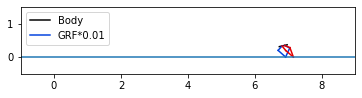

In [24]:
#animate it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

# arrays to store values
N_time = []

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([x_low_lim,x_high_lim+3.0])
    ax.set_ylim([y_low_lim,y_high_lim])
    N_time.append(i)
     
    plot_body = {}
    plot_url = {}
    plot_lrl = {}
    plot_ull = {}
    plot_lll = {}
    plot_foot = {}
    abs_angles = {}
    
    # plot body
    plot_body.update({('x_back'):m.q[i,'x_body'].value - 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_back'):m.q[i,'y_body'].value - 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})
    plot_body.update({('x_front'):m.q[i,'x_body'].value + 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_front'):m.q[i,'y_body'].value + 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})  
    ax.plot([plot_body['x_back'],plot_body['x_front']],[plot_body['y_back'],plot_body['y_front']],color='xkcd:black')

    for leg in legs:
        if leg == 'A':
            link_colour = ['blue','red']
        else:
            link_colour = ['red','purple']
        
        
        #plot upper right
        abs_angles.update({('RU',leg): m.q[i,'theta_body'].value + m.q[i,'theta_url'+leg].value})
        plot_url.update({('top','X',leg): m.q[i,'x_body'].value + 0.5*m.LL.value*cos(m.q[i,'theta_body'].value)})
        plot_url.update({('top','Y',leg): m.q[i,'y_body'].value + 0.5*m.LL.value*sin(m.q[i,'theta_body'].value)})
        plot_url.update({('bot','X',leg): m.q[i,'x_body'].value + 0.5*m.LL.value*cos(m.q[i,'theta_body'].value) - m.lengths['url'+leg]*cos(abs_angles['RU',leg])})
        plot_url.update({('bot','Y',leg): m.q[i,'y_body'].value + 0.5*m.LL.value*sin(m.q[i,'theta_body'].value) - m.lengths['url'+leg]*sin(abs_angles['RU',leg])})
        ax.plot([plot_url['top','X',leg],plot_url['bot','X',leg]],[plot_url['top','Y',leg],plot_url['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))
        
        #plot lower right
        abs_angles.update({('RL',leg): m.q[i,'theta_lrl'+leg].value - (np.pi-abs_angles['RU',leg])})
        plot_lrl.update({('top','X',leg): plot_url['bot','X',leg]})
        plot_lrl.update({('top','Y',leg): plot_url['bot','Y',leg]})
        plot_lrl.update({('bot','X',leg): plot_url['bot','X',leg] - m.lengths['lrl'+leg]*cos(abs_angles['RL',leg])})
        plot_lrl.update({('bot','Y',leg): plot_url['bot','Y',leg] - m.lengths['lrl'+leg]*sin(abs_angles['RL',leg])})
        ax.plot([plot_lrl['top','X',leg],plot_lrl['bot','X',leg]],[plot_lrl['top','Y',leg],plot_lrl['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

        #plot upper left
        abs_angles.update({('LU',leg): m.q[i,'theta_body'].value + m.q[i,'theta_ull'+leg].value})
        plot_ull.update({('top','X',leg): m.q[i,'x_body'].value - 0.5*m.LL.value*cos(m.q[i,'theta_body'].value)})
        plot_ull.update({('top','Y',leg): m.q[i,'y_body'].value - 0.5*m.LL.value*sin(m.q[i,'theta_body'].value)})
        plot_ull.update({('bot','X',leg): m.q[i,'x_body'].value - 0.5*m.LL.value*cos(m.q[i,'theta_body'].value) - m.lengths['ull'+leg]*cos(abs_angles['LU',leg])})
        plot_ull.update({('bot','Y',leg): m.q[i,'y_body'].value - 0.5*m.LL.value*sin(m.q[i,'theta_body'].value) - m.lengths['ull'+leg]*sin(abs_angles['LU',leg])})
        ax.plot([plot_ull['top','X',leg],plot_ull['bot','X',leg]],[plot_ull['top','Y',leg],plot_ull['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

        #plot lower left
        abs_angles.update({('LL',leg):m.q[i,'theta_lll'+leg].value - (np.pi-abs_angles['LU',leg])})
        plot_lll.update({('top','X',leg): plot_ull['bot','X',leg]})
        plot_lll.update({('top','Y',leg): plot_ull['bot','Y',leg]})
        plot_lll.update({('bot','X',leg): plot_ull['bot','X',leg] - m.lengths['lll'+leg]*cos(abs_angles['LL',leg])})
        plot_lll.update({('bot','Y',leg): plot_ull['bot','Y',leg] - m.lengths['lll'+leg]*sin(abs_angles['LL',leg])})
        ax.plot([plot_lll['top','X',leg],plot_lll['bot','X',leg]],[plot_lll['top','Y',leg],plot_lll['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))     
    
    
    if m.GRF_y[i,'A'].value > 0.0:
        #print('GRF_footR = ',m.GRF_y[i,'footR'].value)
        ax.arrow(plot_lll['bot','X','A'], plot_lll['bot','Y','A'], 0, 0.01*m.GRF_y[i,'A'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)
        
    if m.GRF_y[i,'B'].value > 0.0:
        #print('GRF_footL = ',m.GRF_y[i,'footL'].value)
        ax.arrow(plot_lrl['bot','X','B'], plot_lrl['bot','Y','B'], 0, 0.01*m.GRF_y[i,'B'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)
    
    ax.legend(["Body","GRF*0.01"], frameon=True)
    
    ax.plot([-10,10],[0,0]) # plot the ground
    
    
update = lambda i: plot_robot(i,m,ax1) # lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


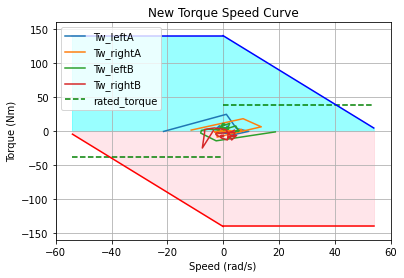

In [25]:
f = r"{0}_biped.mp4".format(test) 
writervideo = ani.FFMpegWriter(fps=20) 
animate.save(f, writer=writervideo) 
vel = 0.0

nodes = []

xbody = []
ybody = []
thbody = []
thullA = []
thurlA = []
thlllA = []
thlrlA = []
thullB = []
thurlB = []
thlllB = []
thlrlB = []



dxbody = []
dybody = []
dthbody = []
dthullA = []
dthurlA = []
dthlllA = []
dthlrlA = []
dthullB = []
dthurlB = []
dthlllB = []
dthlrlB = []

ddxbody = []
ddybody = []
ddthbody = []
ddthullA = []
ddthurlA = []
ddthlllA = []
ddthlrlA = []
ddthullB = []
ddthurlB = []
ddthlllB = []
ddthlrlB = []

Torque_leftA = []
Torque_rightA = []
Torque_leftB = []
Torque_rightB = []

GRF_y_A = []
GRF_y_B = []

angular_speed_leftA = []
angular_speed_rightA = []
angular_speed_leftB = []
angular_speed_rightB = []



for n in range(1,N+1):
    
    xbody.append(m.q[n,'x_body'].value)
    ybody.append(m.q[n,'y_body'].value)
    thbody.append(m.q[n,'theta_body'].value)
    thullA.append(m.q[n,'theta_ullA'].value) 
    thurlA.append(m.q[n,'theta_urlA'].value) 
    thlllA.append(m.q[n,'theta_lllA'].value) 
    thlrlA.append(m.q[n,'theta_lrlA'].value) 
    thullB.append(m.q[n,'theta_ullB'].value) 
    thurlB.append(m.q[n,'theta_urlB'].value) 
    thlllB.append(m.q[n,'theta_lllB'].value) 
    thlrlB.append(m.q[n,'theta_lrlB'].value) 

    dxbody.append(m.dq[n,'x_body'].value)
    dybody.append(m.dq[n,'y_body'].value)
    dthbody.append(m.dq[n,'theta_body'].value)
    dthullA.append(m.dq[n,'theta_ullA'].value) 
    dthurlA.append(m.dq[n,'theta_urlA'].value) 
    dthlllA.append(m.dq[n,'theta_lllA'].value) 
    dthlrlA.append(m.dq[n,'theta_lrlA'].value) 
    dthullB.append(m.dq[n,'theta_ullB'].value) 
    dthurlB.append(m.dq[n,'theta_urlB'].value) 
    dthlllB.append(m.dq[n,'theta_lllB'].value) 
    dthlrlB.append(m.dq[n,'theta_lrlB'].value) 

    ddxbody.append(m.ddq[n,'x_body'].value)
    ddybody.append(m.ddq[n,'y_body'].value)
    ddthbody.append(m.ddq[n,'theta_body'].value)
    ddthullA.append(m.ddq[n,'theta_ullA'].value) 
    ddthurlA.append(m.ddq[n,'theta_urlA'].value) 
    ddthlllA.append(m.ddq[n,'theta_lllA'].value) 
    ddthlrlA.append(m.ddq[n,'theta_lrlA'].value) 
    ddthullB.append(m.ddq[n,'theta_ullB'].value) 
    ddthurlB.append(m.ddq[n,'theta_urlB'].value) 
    ddthlllB.append(m.ddq[n,'theta_lllB'].value) 
    ddthlrlB.append(m.ddq[n,'theta_lrlB'].value) 

    Torque_leftA.append(m.tau_torque[n,'left','A'].value)
    Torque_rightA.append(m.tau_torque[n,'right','A'].value)
    Torque_leftB.append(m.tau_torque[n,'left','B'].value)
    Torque_rightB.append(m.tau_torque[n,'right','B'].value)

    GRF_y_A.append(m.GRF_y[n,'A'].value)
    GRF_y_B.append(m.GRF_y[n,'B'].value)

    angular_speed_leftA.append(m.tau_velocity[n,'left','A'].value) 
    angular_speed_rightA.append(m.tau_velocity[n,'right','A'].value)
    angular_speed_leftB.append(m.tau_velocity[n,'left','B'].value)
    angular_speed_rightB.append(m.tau_velocity[n,'right','B'].value)
    
    nodes.append(n)
    
    
    #print(m.q[n,'y_body'].value)
    #print(m.q[n,'{r_prismatic}_{footL}'].value)
    #print(m.foot_position[n, 'Y', 'footR'].value)
    #print(m.q[n,'y_body'].value)
    #print(m.dq[n,'x_body'].value)
    #vel = vel + m.dq[n,'x_body'].value
    #print(m.GRF_y[n,'footL'].value)
    #print(m.tau_torque[n,'left'].value)
    pass



''' Store first values in csv file '''
import csv
# csv_file_name = str(int(V_avg))+'_u{0}'.format(mu_value)
csv_file_name = "Test_{0}_N_{1}_TT_{2}".format(test,N,str(int(TT)))

heading0 = ['node']
heading1 = ['x_body','y_body','theta_body','theta_ullA','theta_urlA','theta_lllA','theta_lrlA','theta_ullB','theta_urlB','theta_lllB','theta_lrlB']
heading2 = ['dx_body','dy_body','dtheta_body','dtheta_ullA','dtheta_urlA','dtheta_lllA','dtheta_lrlA','dtheta_ullB','dtheta_urlB','dtheta_lllB','dtheta_lrlB']
heading3 = ['ddx_body','ddy_body','ddtheta_body','ddtheta_ullA','ddtheta_urlA','ddtheta_lllA','ddtheta_lrlA','ddtheta_ullB','ddtheta_urlB','ddtheta_lllB','ddtheta_lrlB']
heading4 = ['Tau_leftA','Tau_rightA','Tau_leftB','Tau_rightB', 'GRF_yA','GRF_yB']
heading = heading0 + heading1 + heading2 + heading3 + heading4

with open(csv_file_name+'.csv', 'w') as f:
    writer = csv.writer(f)

    writer.writerow(heading)

    for n in range(N):
        node = [n]
        data1 = [xbody[n],ybody[n],thbody[n],thullA[n],thurlA[n],thlllA[n],thlrlA[n],thullB[n],thurlB[n],thlllB[n],thlrlB[n]]
        data2 = [dxbody[n],dybody[n],dthbody[n],dthullA[n],dthurlA[n],dthlllA[n],dthlrlA[n],dthullB[n],dthurlB[n],dthlllB[n],dthlrlB[n]]
        data3 = [ddxbody[n],ddybody[n],ddthbody[n],ddthullA[n],ddthurlA[n],ddthlllA[n],ddthlrlA[n],ddthullB[n],ddthurlB[n],ddthlllB[n],ddthlrlB[n]]
        data4 = [Torque_leftA[n],Torque_rightA[n],Torque_leftB[n],Torque_rightB[n],GRF_y_A[n],GRF_y_B[n]]
        data = node + data1 + data2 + data3 + data4
        writer.writerow(data)
        
csv_file_name2 = "Test_{0}_N_{1}_TT_{2}".format(test,N,str(int(TT)))        
with open("NOTE_"+csv_file_name2 + ".csv" , 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['ground_penalty','status','mu','TT','N','h_lower','h_higher'])
    writer.writerow([pen_sum,results.solver.termination_condition,mu_value,TT,N,h_lower_bound,h_higher_bound])
        
    

plt.figure()
plt.plot(angular_speed_leftA,Torque_leftA)
plt.plot(angular_speed_rightA,Torque_rightA)
plt.plot(angular_speed_leftB,Torque_leftB)
plt.plot(angular_speed_rightB,Torque_rightB)

plt.grid()
plt.plot(x_p,rated_torque_p,color = 'green',linestyle = '--')
plt.plot(x_n,rated_torque_n,color = 'green',linestyle = '--')

plt.plot(x_p, y_p,'b')
plt.plot(x_n, stall_torque_p,'b')

plt.fill_between(x_p, y_p, alpha=0.4, color = 'cyan')
plt.fill_between(x_n, stall_torque_p, alpha=0.4,color = 'cyan')

plt.plot(x_n, y_n,'r')
plt.plot(x_p, stall_torque_n,'r')

plt.fill_between(x_n, y_n, alpha=0.4,color = 'pink')
plt.fill_between(x_p, stall_torque_n, alpha=0.4,color = 'pink')

plt.axis((-60,60,-160,160))
plt.title('New Torque Speed Curve')
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')
plt.legend(["Tw_leftA", "Tw_rightA","Tw_leftB", "Tw_rightB","rated_torque"], loc=0, frameon=True)

In [26]:
# try: 
#     # solving
#     opt = SolverFactory('ipopt',executable = '/home/uct/Trajectory_Optimization/IPOPT/build/bin/ipopt')
#     opt.options["linear_solver"] = 'ma86'

#     # solver options
#     opt.options["expect_infeasible_problem"] = 'yes'
#     #pt.options["linear_system_scaling"] = 'none'
#     #opt.options["mu_strategy"] = "adaptive"
#     opt.options["print_level"] = 5     # prints a log with each iteration (you want to this - it's the only way to see progress.)
#     opt.options["max_iter"] = 30000*10   # maximum number of iterations
#     opt.options["max_cpu_time"] = 600*10  # maximum cpu time in seconds
#     opt.options["Tol"] = 1e-6          # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.

#     results = opt.solve(m, tee = True)

#     ###########################################################################################################

#     # PLOT COST FUNCTION -------------------------------------------------------------------------------------------------------------
#     # T = sum(m.h[n] for n in range(1,N+1))
#     pen_sum = 0.0
#     for n in range(1,N+1):
#             for gc in ground_constraints:
#                 for leg in legs:
#                     pen_sum += m.ground_penalty[n,gc,leg].value
#     print(pen_sum)

#     ###########################################################################################################

#     #animate it
#     import matplotlib
#     import matplotlib.pyplot as plt
#     import matplotlib.animation as ani
#     from IPython.display import HTML
#     %matplotlib inline

#     fig1, ax1 = plt.subplots(1,1) #create axes
#     ax1.set_aspect('equal')

#     # arrays to store values
#     N_time = []

#     def plot_robot(i,m,ax): #update function for animation
#         ax.clear()
#         ax.set_xlim([x_low_lim,x_high_lim])
#         ax.set_ylim([y_low_lim,y_high_lim])
#         N_time.append(i)

#         plot_body = {}
#         plot_url = {}
#         plot_lrl = {}
#         plot_ull = {}
#         plot_lll = {}
#         plot_foot = {}
#         abs_angles = {}

#         # plot body
#         plot_body.update({('x_back'):m.q[i,'x_body'].value - 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
#         plot_body.update({('y_back'):m.q[i,'y_body'].value - 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})
#         plot_body.update({('x_front'):m.q[i,'x_body'].value + 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
#         plot_body.update({('y_front'):m.q[i,'y_body'].value + 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})  
#         ax.plot([plot_body['x_back'],plot_body['x_front']],[plot_body['y_back'],plot_body['y_front']],color='xkcd:black')

#         for leg in legs:
#             if leg == 'A':
#                 link_colour = ['blue','red']
#             else:
#                 link_colour = ['red','purple']


#             #plot upper right
#             abs_angles.update({('RU',leg): m.q[i,'theta_body'].value + m.q[i,'theta_url'+leg].value})
#             plot_url.update({('top','X',leg): m.q[i,'x_body'].value + 0.5*m.LL.value*cos(m.q[i,'theta_body'].value)})
#             plot_url.update({('top','Y',leg): m.q[i,'y_body'].value + 0.5*m.LL.value*sin(m.q[i,'theta_body'].value)})
#             plot_url.update({('bot','X',leg): m.q[i,'x_body'].value + 0.5*m.LL.value*cos(m.q[i,'theta_body'].value) - m.lengths['url'+leg]*cos(abs_angles['RU',leg])})
#             plot_url.update({('bot','Y',leg): m.q[i,'y_body'].value + 0.5*m.LL.value*sin(m.q[i,'theta_body'].value) - m.lengths['url'+leg]*sin(abs_angles['RU',leg])})
#             ax.plot([plot_url['top','X',leg],plot_url['bot','X',leg]],[plot_url['top','Y',leg],plot_url['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

#             #plot lower right
#             abs_angles.update({('RL',leg): m.q[i,'theta_lrl'+leg].value - (np.pi-abs_angles['RU',leg])})
#             plot_lrl.update({('top','X',leg): plot_url['bot','X',leg]})
#             plot_lrl.update({('top','Y',leg): plot_url['bot','Y',leg]})
#             plot_lrl.update({('bot','X',leg): plot_url['bot','X',leg] - m.lengths['lrl'+leg]*cos(abs_angles['RL',leg])})
#             plot_lrl.update({('bot','Y',leg): plot_url['bot','Y',leg] - m.lengths['lrl'+leg]*sin(abs_angles['RL',leg])})
#             ax.plot([plot_lrl['top','X',leg],plot_lrl['bot','X',leg]],[plot_lrl['top','Y',leg],plot_lrl['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

#             #plot upper left
#             abs_angles.update({('LU',leg): m.q[i,'theta_body'].value + m.q[i,'theta_ull'+leg].value})
#             plot_ull.update({('top','X',leg): m.q[i,'x_body'].value - 0.5*m.LL.value*cos(m.q[i,'theta_body'].value)})
#             plot_ull.update({('top','Y',leg): m.q[i,'y_body'].value - 0.5*m.LL.value*sin(m.q[i,'theta_body'].value)})
#             plot_ull.update({('bot','X',leg): m.q[i,'x_body'].value - 0.5*m.LL.value*cos(m.q[i,'theta_body'].value) - m.lengths['ull'+leg]*cos(abs_angles['LU',leg])})
#             plot_ull.update({('bot','Y',leg): m.q[i,'y_body'].value - 0.5*m.LL.value*sin(m.q[i,'theta_body'].value) - m.lengths['ull'+leg]*sin(abs_angles['LU',leg])})
#             ax.plot([plot_ull['top','X',leg],plot_ull['bot','X',leg]],[plot_ull['top','Y',leg],plot_ull['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

#             #plot lower left
#             abs_angles.update({('LL',leg):m.q[i,'theta_lll'+leg].value - (np.pi-abs_angles['LU',leg])})
#             plot_lll.update({('top','X',leg): plot_ull['bot','X',leg]})
#             plot_lll.update({('top','Y',leg): plot_ull['bot','Y',leg]})
#             plot_lll.update({('bot','X',leg): plot_ull['bot','X',leg] - m.lengths['lll'+leg]*cos(abs_angles['LL',leg])})
#             plot_lll.update({('bot','Y',leg): plot_ull['bot','Y',leg] - m.lengths['lll'+leg]*sin(abs_angles['LL',leg])})
#             ax.plot([plot_lll['top','X',leg],plot_lll['bot','X',leg]],[plot_lll['top','Y',leg],plot_lll['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))     


#         if m.GRF_y[i,'A'].value > 0.0:
#             #print('GRF_footR = ',m.GRF_y[i,'footR'].value)
#             ax.arrow(plot_lll['bot','X','A'], plot_lll['bot','Y','A'], 0, 0.01*m.GRF_y[i,'A'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)

#         if m.GRF_y[i,'B'].value > 0.0:
#             #print('GRF_footL = ',m.GRF_y[i,'footL'].value)
#             ax.arrow(plot_lrl['bot','X','B'], plot_lrl['bot','Y','B'], 0, 0.01*m.GRF_y[i,'B'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)

#         ax.legend(["Body","GRF*0.01"], frameon=True)

#         ax.plot([-10,10],[0,0]) # plot the ground


#     update = lambda i: plot_robot(i,m,ax1) # lambdify update function

#     animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

#     HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook

#     ###########################################################################################################

#     import os

#     # Directory
#     directory = "Test_{0}_N_{1}_TT_{2}".format(test,N,str(int(TT)))

#     # Parent Directory path
#     parent_dir = "BRAKING_8ms"

#     # Path
#     path = os.path.join(parent_dir, directory) 
#     os.mkdir(path)

#     csv_file_name = directory
#     #with open(os.path.join(parent_dir, directory,directory)+'.csv', 'w') as f:
#     with open("BRAKING_8ms/{0}/Results.csv".format(directory) , 'w') as f:
#         writer = csv.writer(f)
#         writer.writerow(['ground_penalty','status','mu','TT','N','h_lower','h_higher'])
#         writer.writerow([pen_sum,results.solver.termination_condition,mu_value,TT,N,h_lower_bound,h_higher_bound])

#     import csv
#     #csv_file_name = str(int(V_avg))+'.csv'

#     heading0 = ['node']
#     heading1 = ['x_body','y_body','theta_body','theta_ullA','theta_urlA','theta_lllA','theta_lrlA','theta_ullB','theta_urlB','theta_lllB','theta_lrlB']
#     heading2 = ['dx_body','dy_body','dtheta_body','dtheta_ullA','dtheta_urlA','dtheta_lllA','dtheta_lrlA','dtheta_ullB','dtheta_urlB','dtheta_lllB','dtheta_lrlB']
#     heading3 = ['ddx_body','ddy_body','ddtheta_body','ddtheta_ullA','ddtheta_urlA','ddtheta_lllA','ddtheta_lrlA','ddtheta_ullB','ddtheta_urlB','ddtheta_lllB','ddtheta_lrlB']
#     heading4 = ['Tau_leftA','Tau_rightA','Tau_leftB','Tau_rightB']
#     heading = heading0 + heading1 + heading2 + heading3 + heading4

#     with open("BRAKING_8ms/{0}/Data.csv".format(directory), 'w') as f:
#         writer = csv.writer(f)

#         writer.writerow(heading)

#         for n in range(N):
#             node = [n]
#             data1 = [xbody[n],ybody[n],thbody[n],thullA[n],thurlA[n],thlllA[n],thlrlA[n],thullB[n],thurlB[n],thlllB[n],thlrlB[n]]
#             data2 = [dxbody[n],dybody[n],dthbody[n],dthullA[n],dthurlA[n],dthlllA[n],dthlrlA[n],dthullB[n],dthurlB[n],dthlllB[n],dthlrlB[n]]
#             data3 = [ddxbody[n],ddybody[n],ddthbody[n],ddthullA[n],ddthurlA[n],ddthlllA[n],ddthlrlA[n],ddthullB[n],ddthurlB[n],ddthlllB[n],ddthlrlB[n]]
#             data4 = [Torque_leftA[n],Torque_rightA[n],Torque_leftB[n],Torque_rightB[n]]
#             data = node + data1 + data2 + data3 + data4
#             writer.writerow(data)    

#     plt.figure()
#     plt.plot(angular_speed_leftA,Torque_leftA)
#     plt.plot(angular_speed_rightA,Torque_rightA)
#     plt.plot(angular_speed_leftB,Torque_leftB)
#     plt.plot(angular_speed_rightB,Torque_rightB)

#     plt.grid()
#     plt.plot(x_p,rated_torque_p,color = 'green',linestyle = '--')
#     plt.plot(x_n,rated_torque_n,color = 'green',linestyle = '--')

#     plt.plot(x_p, y_p,'b')
#     plt.plot(x_n, stall_torque_p,'b')

#     plt.fill_between(x_p, y_p, alpha=0.4, color = 'cyan')
#     plt.fill_between(x_n, stall_torque_p, alpha=0.4,color = 'cyan')

#     plt.plot(x_n, y_n,'r')
#     plt.plot(x_p, stall_torque_n,'r')

#     plt.fill_between(x_n, y_n, alpha=0.4,color = 'pink')
#     plt.fill_between(x_p, stall_torque_n, alpha=0.4,color = 'pink')

#     plt.axis((-60,60,-160,160))
#     plt.title('New Torque Speed Curve')
#     plt.xlabel('Speed (rad/s)')
#     plt.ylabel('Torque (Nm)')
#     plt.legend(["Tw_leftA", "Tw_rightA","Tw_leftB", "Tw_rightB","rated_torque"], loc=0, frameon=True)
#     plt.savefig("BRAKING_8ms/{0}/Torque_Speed.jpg".format(directory))

#     f = r"BRAKING_8ms/{0}/{1}_biped.mp4".format(directory,test) 
#     writervideo = ani.FFMpegWriter(fps=20) 
#     animate.save(f, writer=writervideo)   
# except:
#     pass

In [27]:
N

100

In [28]:
m.connect_force[50,'Y','B'].value

-22.821029170119086

In [33]:
m.dq[1,'x_body'].value
# max(xbody)

8.108322799483794

<a href='#initial_conditions'>Link to initial conditions'</a>

<a href='#Select_Test'>Link to Test Selection'</a>